<hr style="height:0px; visibility:hidden;" />

<h1><center><b>GL4U: RNAseq<b></center></h1>

# Pipeline for Analyzing GeneLab RNA-sequencing Data

> **The 2 GL4U RNAseq Jupyter Notebooks (JNs) are designed to teach students how to process and analyze RNA sequencing data using the GeneLab standard pipeline. This optional 3rd Jupyter Notebook (JN) was built to allow students to apply what they've learned to perform differential gene expression (DGE) analysis with DESeq2 on a RNAseq dataset of their choosing. Below is a modified version of the 02-RNAseq_analysis JN that includes step-by-step instructions for determining differentially expressed genes in a select pairwise group comparison in any RNAseq GeneLab Data Set (GLDS) hosted on the [Open Science Data Repository (OSDR)](https://osdr.nasa.gov/bio/repo), starting with RSEM raw counts data. This JN uses the [GeneLab standard pipeline, version F](https://github.com/nasa/GeneLab_Data_Processing/blob/master/RNAseq/Pipeline_GL-DPPD-7101_Versions/GL-DPPD-7101-F.md).** 
>   - Note: Since this JN requires RSEM raw counts data as input, only GLDS datasets that have raw counts data available on OSDR can be analyzed.

---

### RNAseq Pipeline Overview
> This JN will cover the pipeline steps outlined in red. For more information about how GeneLab processes bulk RNAseq data, visit the [GeneLab Data Processing GitHub repository](https://github.com/nasa/GeneLab_Data_Processing/tree/master/RNAseq).  

<br>

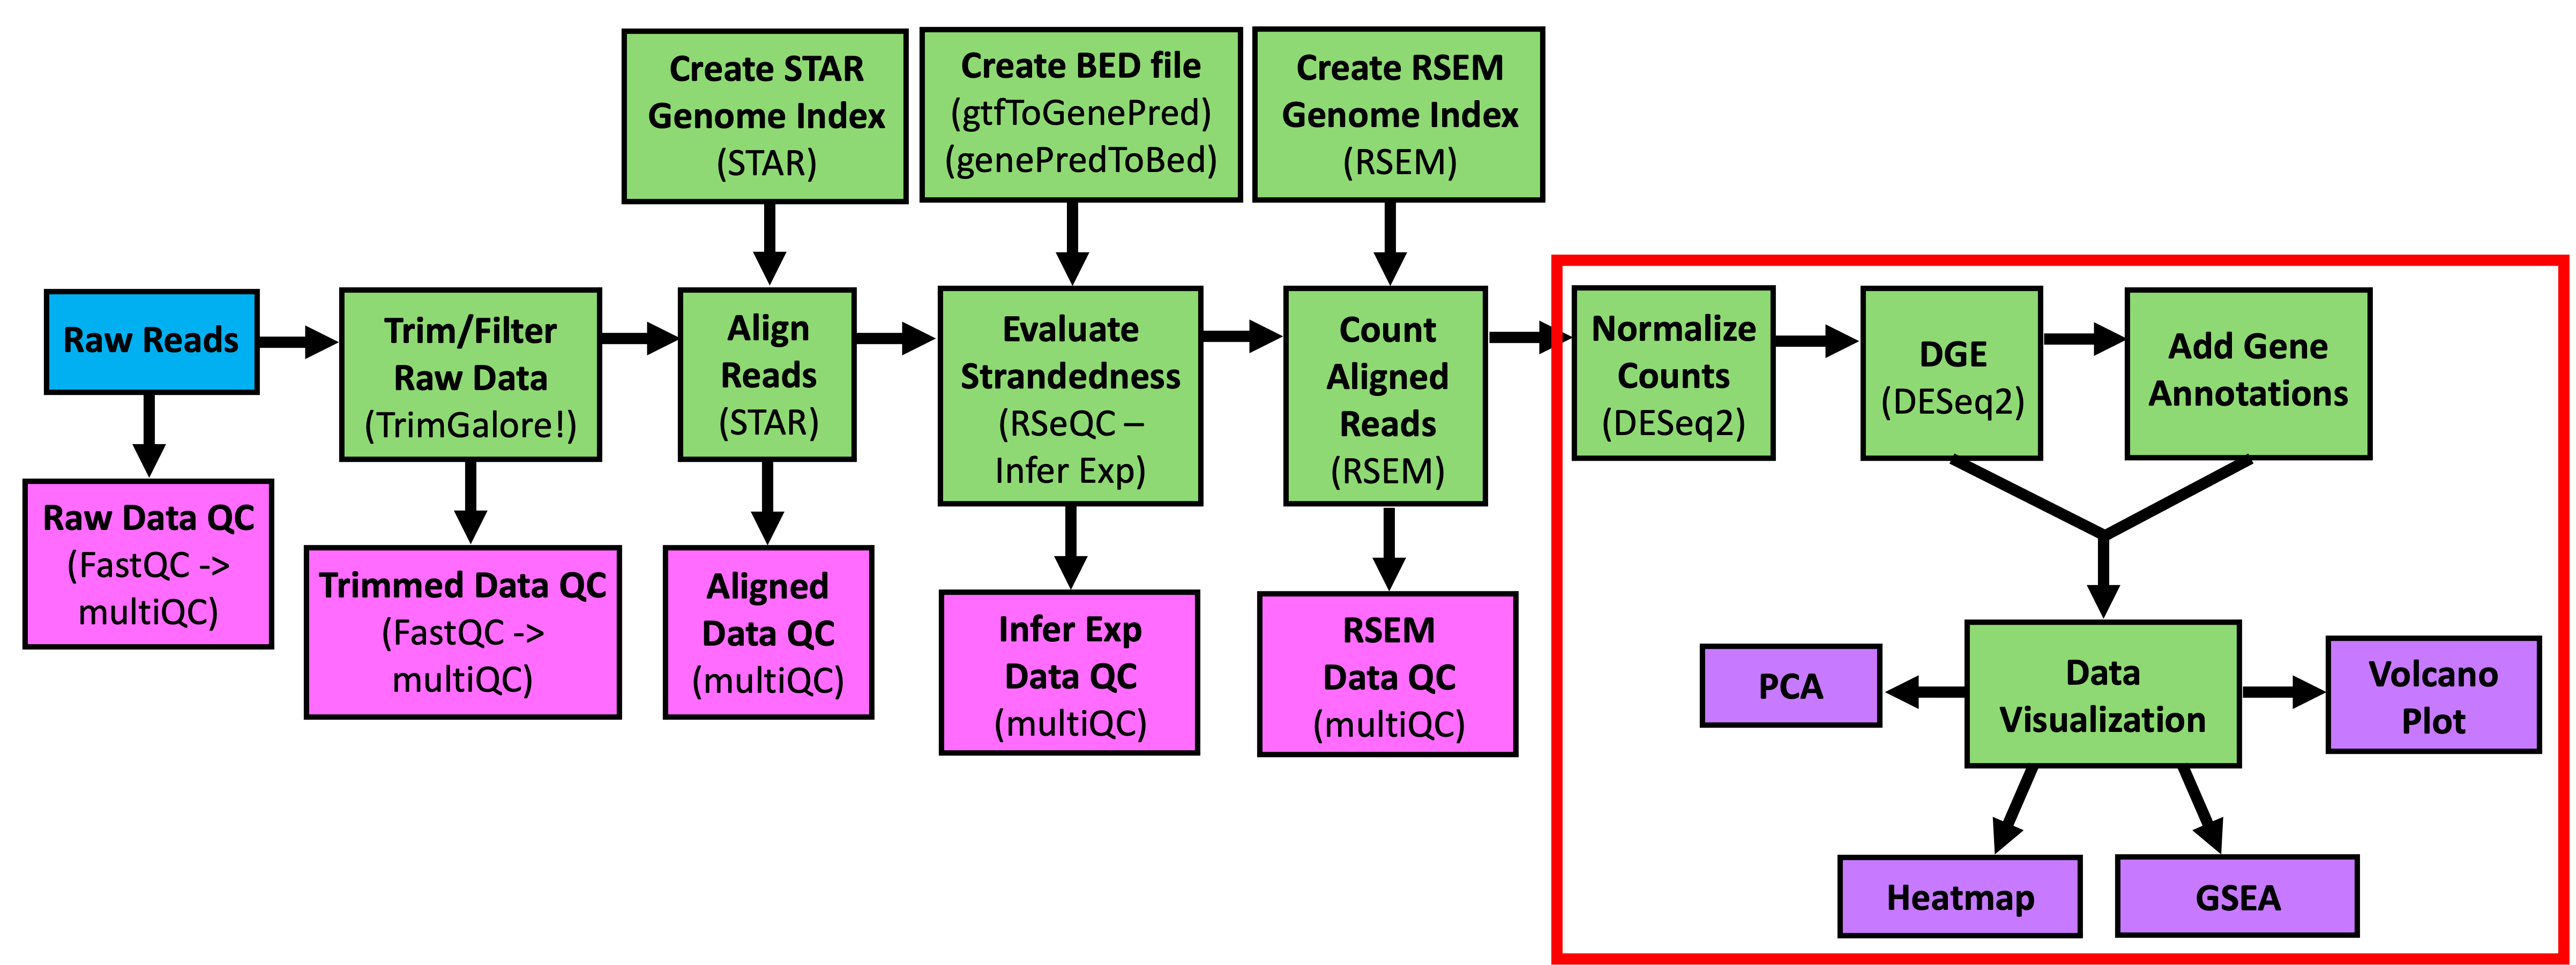

<hr style="height:0px; visibility:hidden;" />
    
<h1><center>3. RNAseq analysis of any OSD/GLDS dataset: DGE, annotations, and data visualization</center></h1>

<div class="alert alert-block alert-success">
Here we are going to download and format the input metadata and data files from any RNAseq dataset on OSDR that contains the *.genes.results output files from RSEM. We will next setup a directory structure to store the output data we'll generate. Then we will follow the steps in the GeneLab standard RNAseq processing pipeline to perform differential gene expression (DGE), add annotations, and generate data visualizations.  
</div>

---

This is a modified version of the 2nd notebook of GL4U's RNAseq Module Set. It is expected that both the GL4U Introduction Module Set and the RNAseq Module Set have been completed already. 

---
[**Previous:** 2. RNAseq analysis](02-RNAseq_analysis.ipynb)
<br>

---
---

# Table of Contents 


* [0. Create Directory Structure for Processed Data](#0.-Create-Directory-Structure-for-Processed-Data)
* [1. Download the Metadata and Data](#1.-Download-the-Metadata-and-Data)
    * [1a. Set up Directory Path Variables](#1a.-Set-up-Directory-Path-Variables)
    * [1b. Download and Format the Metadata](#1b.-Download-and-Format-the-Metadata)
    * [1c. Download the Raw Counts Files](#1c.-Download-the-Raw-Counts-Files)
* [2. Import and Format the Metadata and Data in R](#2.-Import-and-Format-the-Metadata-and-Data-in-R)
    * [2a. Load R Libraries](#2a.-Load-R-Libraries)
    * [2b. Set up Directory Path Variables in R](#2b.-Set-up-Directory-Path-Variables-in-R)
    * [2c. Import and Format Sample Metadata in R](#2c.-Import-and-Format-Sample-Metadata-in-R)
    * [2d. Import and Format Raw Counts Data in R](#2d.-Import-and-Format-Raw-Counts-Data-in-R)
    * [2e. Make DESeqDataSet Object](#2e.-Make-DESeqDataSet-Object)
* [3. DESeq2 Data Normalization](#3.-DESeq2-Data-Normalization)
    * [3a. PCA of Raw, Unnormalized Count Data](#3a.-PCA-of-Raw,-Unnormalized-Count-Data)
    * [3b. DESeq2 Step 1: Size Factor Estimation](#3b.-DESeq2-Step-1:-Size-Factor-Estimation)
    * [3c. DESeq2 Step 2: Estimate Gene Dispersions](#3c.-DESeq2-Step-2:-Estimate-Gene-Dispersions)
    * [3d. DESeq2 Step 3: Hypothesis Testing with Wald Test](#3d.-DESeq2-Step-3:-Hypothesis-Testing-with-Wald-Test)
* [4. DGE Analysis](#4.-DGE-Analysis)
    * [4a. Perform Data Calculations and Create DGE Output Table](#4a.-Perform-Data-Calculations-and-Create-DGE-Output-Table)
    * [4b. Add Gene Annotations](#4b.-Add-Gene-Annotations)
* [5. DGE Data Visualization](#5.-DGE-Data-Visualization)
    * [5a. PCA](#5a.-PCA)
    * [5b. Heatmap](#5b.-Heatmap)
    * [5c. Volcano Plot](#5c.-Volcano-Plot)
    * [5d. Gene Set Enrichment Analysis (GSEA)](#5d.-Gene-Set-Enrichment-Analysis-(GSEA))
* [6. So now what?](6.-So-now-what?)

---

**Note: This JN uses Bash and R kernels. The kernel used is indicated under each section title.**

---

<a class="anchor" id="dirstructure"></a>
# 0. Create Directory Structure for Processed Data
> **Required kernel:** Bash

In the code block below, define the OSD/GLDS dataset you want to process by replacing `OSD-###` and `GLDS-###` with the appropriate OSD and GLDS number for your select dataset indicated in [OSDR](https://osdr.nasa.gov/bio/repo):

In [1]:
OSD=OSD-759
GLDS=GLDS-665

Before running any analyses, let's move to the location that contains the files we will use in this JN then create a directory structure to store the data. Throughout this JN, you will download and generate several files so it is important to keep these files organized.

We'll start by moving to the location that contains the files we will use in this JN:

In [2]:
cd /workspace/GeneLab-Training/
pwd

/workspace/GeneLab-Training


Create a top level directory for your selected OSD/GLDS dataset number:

In [3]:
mkdir ${OSD}_${GLDS}

The next series of commands will be used to create sub-directories within the OSD-###_GLDS-### top-level directory you just created (with the command above) to store the data from each step in the RNAseq processing pipeline, starting with RSEM counts files.

Create sub-directory for metadata:

In [4]:
mkdir ./${OSD}_${GLDS}/Metadata

Create sub-directory for individual, raw count data:

In [5]:
mkdir ./${OSD}_${GLDS}/03-RSEM_Counts

Create sub-directories for combined raw and normalized counts tables and PCA data/plots:

In [6]:
mkdir ./${OSD}_${GLDS}/04-DESeq2_NormCounts
mkdir ./${OSD}_${GLDS}/04-DESeq2_NormCounts/PCA

Create sub-directories for differential expression analysis data:

In [7]:
mkdir ./${OSD}_${GLDS}/05-DESeq2_DGE
mkdir ./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots
mkdir ./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots/PCA
mkdir ./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots/Heatmaps
mkdir ./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots/VolcanoPlots
mkdir ./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots/GSEA

<br>

---

<a class="anchor" id="data"></a>
# 1. Download the Metadata and Data
> **Required kernel:** Bash

<a class="anchor" id="dirs"></a>
## 1a. Set up Directory Path Variables

Let's start by creating variables (in Bash) to define the locations for our input metadata and count data and to indicate the location where the output data will be printed.

In [8]:
metadata_dir=./${OSD}_${GLDS}/Metadata
counts_dir=./${OSD}_${GLDS}/03-RSEM_Counts
norm_output=./${OSD}_${GLDS}/04-DESeq2_NormCounts
pca_dir=./${OSD}_${GLDS}/04-DESeq2_NormCounts/PCA
DGE_output=./${OSD}_${GLDS}/05-DESeq2_DGE
DGE_pca=./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots/PCA
DGE_heatmaps=./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots/Heatmaps
DGE_volcano=./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots/VolcanoPlots
DGE_gsea=./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots/GSEA

<br>

<a class="anchor" id="download"></a>
## 1b. Download and Format the Metadata

To process the data in your select dataset, you'll need to know some information about the samples and experimental design, this information is known as metadata. In [OSDR](https://osdr.nasa.gov/bio/repo), all the metadata for each dataset is held in the downloadable \*ISA.zip file. 

The command in the code block below will execute the `download_files_urls.py` python script, which allows you to download files from any dataset in [OSDR](https://osdr.nasa.gov/bio/repo). The `download_files_urls.py` python script requires the following 3 inputs:
1) The OSD number for your dataset, held in the `OSD` variable you created in [Step 0](#0.-Create-Directory-Structure-for-Processed-Data)
2) The extension of the file(s) you want to download from your dataset, which is the `ISA.zip` file extension on OSDR
3) The location where you want the select files downloaded, which is the metadata sub-directory you created in [Step 0](#0.-Create-Directory-Structure-for-Processed-Data) held in the `metadata_dir` variable assigned above

Run the code block below to download the \*ISA.zip file for your dataset into the metadata sub-directory:

In [9]:
python download_file_urls.py $OSD ISA.zip $metadata_dir/

Fetching for within 'OSD-759'
Pattern: ISA.zip
https://osdr.nasa.gov/genelab/data/glds/files/759
https://osdr.nasa.gov/geode-py/ws/studies/OSD-759/download?source=datamanager&file=OSD-759_metadata_OSD-759-ISA.zip
running: ['curl', 'https://osdr.nasa.gov/geode-py/ws/studies/OSD-759/download?source=datamanager&file=OSD-759_metadata_OSD-759-ISA.zip', '-L', '--create-dirs', '-o', './OSD-759_GLDS-665/Metadata//OSD-759_metadata_OSD-759-ISA.zip']
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3898  100  3898    0     0   6894      0 --:--:-- --:--:-- --:--:--  6899
100  142k  100  142k    0     0   189k      0 --:--:-- --:--:-- --:--:-- 3762k



Check that the \*ISA.zip file has been downloaded to your `Metadata` subdirectory:

In [10]:
ls $metadata_dir/

OSD-759_metadata_OSD-759-ISA.zip


The \*ISA.zip file download above contains several files holding all the metadata associated with your select dataset but you only need a subset of those metadata to perform DGE analysis. Therefore, in the next code block you will use [dp_tools](https://github.com/torres-alexis/dp_tools) to parse the metadata in the \*ISA.zip file and create a runsheet containing the metadata needed to perform DGE analysis then move your output runsheet into the metadata sub-directory:

In [11]:
dpt-isa-to-runsheet --accession $OSD \
    --config-type bulkRNASeq \
    --config-version Latest \
    --isa-archive $metadata_dir/*ISA.zip 

mv *runsheet.csv $metadata_dir/

INFO:dp_tools.scripts.convert:Setting up to generate runsheet dataframe
INFO:dp_tools.core.configuration:Loading config (relative to package): ../config/bulkRNASeq_vLatest.yaml
2025-08-11 06:43:15.345 | DEBUG    | dp_tools.core.files.isa_archive:fetch_isa_files:29 - Extracting ISA Archive to temp directory: /tmp/tmpizpjaoih
2025-08-11 06:43:15.359 | DEBUG    | dp_tools.core.files.isa_archive:fetch_isa_files:29 - Extracting ISA Archive to temp directory: /tmp/tmpibhwmzyr
2025-08-11 06:43:15.373 | DEBUG    | dp_tools.core.files.isa_archive:fetch_isa_files:29 - Extracting ISA Archive to temp directory: /tmp/tmpa9ym93x6
2025-08-11 06:43:15.381 | DEBUG    | dp_tools.core.files.isa_archive:fetch_isa_files:29 - Extracting ISA Archive to temp directory: /tmp/tmpdto28hyf
INFO:dp_tools.scripts.convert:Generating runsheet dataframe
INFO:dp_tools.glds_api.commons:Retrieving table of files for OSD-759
INFO:dp_tools.glds_api.commons:URL Source: https://osdr.nasa.gov/genelab/data/glds/files/759
https

Check that the \*runsheet.csv file has been created and is in your `Metadata` subdirectory:

In [12]:
ls $metadata_dir/

OSD-759_bulkRNASeq_v1_runsheet.csv  OSD-759_metadata_OSD-759-ISA.zip


Use the following code block to view the \*runsheet.csv file:

In [13]:
column -s, -t $metadata_dir/*runsheet.csv 

Sample Name         has_ERCC  organism      paired_end  read1_path                                                                                                                              read2_path                                                                                                                              Factor Value[Spaceflight]  Factor Value[Altered Gravity]  Original Sample Name
MHU-8_ON_FLT_FLT02  True      Mus musculus  True        https://osdr.nasa.gov/geode-py/ws/studies/OSD-759/download?source=datamanager&file=GLDS-665_rna-seq_MHU-8_ON_FLT_FLT02_R1_raw.fastq.gz  https://osdr.nasa.gov/geode-py/ws/studies/OSD-759/download?source=datamanager&file=GLDS-665_rna-seq_MHU-8_ON_FLT_FLT02_R2_raw.fastq.gz  Space Flight               0.33G by centrifugation        MHU-8_ON_FLT_FLT02
MHU-8_ON_FLT_FLT03  True      Mus musculus  True        https://osdr.nasa.gov/geode-py/ws/studies/OSD-759/download?source=datamanager&file=GLDS-665_rna-seq_MHU-8_ON_FLT_FLT03_R1_raw.fastq.

In [14]:
cat $metadata_dir/*runsheet.csv | awk 'END {print NR - 1}'

35


**Take a look at the \*runsheet.csv content and answer the following questions:**

1. What type(s) of information have been added in the runsheet?

2. How many samples are in your dataset?
   > Hint: Add a code block and use the `cat` and `wc -l` commands to count the number of rows in the runsheet (don't forget to subtract one to account for the column names).

3. Which column(s) contain information needed to perform differential gene expression analysis (DGE)? Why?

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The runsheet contains the metadata required for processing bulk RNA sequence datasets through GeneLab's RNAseq consensus processing pipeline as detailed on [GitHub](https://github.com/nasa/GeneLab_Data_Processing/tree/master/RNAseq/Workflow_Documentation/NF_RCP-F/examples/runsheet).

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The number of samples will be the same as the number of samples in the bulk RNA sequencing assay table is the dataset you selected from [OSDR](https://osdr.nasa.gov/bio/repo/). You can quickly determine this number by running on of the following commands:

```bash
cat $metadata_dir/*runsheet.csv | wc -l
```

Then subtract one from the output value to account for the column names.

Or you can run the following command to get the exact number.

```bash
cat $metadata_dir/*runsheet.csv | awk 'END {print NR - 1}'
```


</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

The following columns contain the information needed to perform DGE and assign annotations:

- "Sample Name" and respective "Factor Value" columns to correctly assign each sample to the group it belongs to.
- "has_ERCC" to determine if ERCC genes are present and would need to be removed prior to normalization.
- "organism" to add the correct annotations to the output DGE table.


</details>
</div>

<br>

<br>

<a class="anchor" id="downloadcounts"></a>
## 1c. Download the Raw Counts Files

To perform DGE analysis, in addition to the metadata, you will also need to download the raw gene counts from each sample in your dataset from [OSDR](https://osdr.nasa.gov/bio/repo). The `download_files_urls.py` python script that you used in [Step 1b](#1b.-Download-and-Format-the-Metadata) to download the \*ISA.zip file (containing the metadata) can also be used to download the \*.genes.results file from each sample in your dataset by running the code block below:
> Recall: The \*.genes.results file is the output file generated by [RSEM](https://github.com/deweylab/RSEM) that contains the expression estimates per gene.

In [15]:
python download_file_urls.py $OSD genes.results $counts_dir

Fetching for within 'OSD-759'
Pattern: genes.results
https://osdr.nasa.gov/genelab/data/glds/files/759
https://osdr.nasa.gov/geode-py/ws/studies/OSD-759/download?source=datamanager&file=GLDS-665_rna_seq_MHU-8_ON_HGC_HGC12.genes.results
running: ['curl', 'https://osdr.nasa.gov/geode-py/ws/studies/OSD-759/download?source=datamanager&file=GLDS-665_rna_seq_MHU-8_ON_HGC_HGC12.genes.results', '-L', '--create-dirs', '-o', './OSD-759_GLDS-665/03-RSEM_Counts/GLDS-665_rna_seq_MHU-8_ON_HGC_HGC12.genes.results']
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3964  100  3964    0     0   7049      0 --:--:-- --:--:-- --:--:--  7053
100 5530k  100 5530k    0     0  6134k      0 --:--:-- --:--:-- --:--:-- 54.1M
https://osdr.nasa.gov/geode-py/ws/studies/OSD-759/download?source=datamanager&file=GLDS-665_rna_seq_MHU-8_ON_HGC_HGC11.genes.results
running: ['curl', 'https://osdr.nasa.gov/geod

Check that the \*genes.results files have been downloaded to your `03-RSEM_Counts` subdirectory:

In [16]:
ls -1 $counts_dir

GLDS-665_rna_seq_MHU-8_ON_FLT_FLT02.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT03.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT04.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT05.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT06.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT07.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT08.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT09.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT10.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT11.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT12.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT13.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT14.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT15.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT16.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT17.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT18.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT19.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT20.genes.results
GLDS-665_rna_seq_MHU-8_ON_FLT_FLT21.genes.results


Count the \*genes.results files to make sure the number of files match the number of samples in your dataset:

In [17]:
ls -1 $counts_dir/*genes.results | wc -l

35


Remove the "GLDS-###\_rna_seq_" prefix from all \*genes.results files:
> This is done so that the file names match the sample names in the \*runsheet.csv file created in [Step 1b](#1b.-Download-and-Format-the-Metadata) above, which is required for [Step 2d](#2d.-Import-and-Format-Raw-Counts-Data-in-R) below.

In [18]:
find $counts_dir/ -name "*genes.results" | sed -e "p;s/${GLDS}_rna_seq_//" | xargs -n2 mv

Check that the "GLDS-###\_rna_seq_" prefix has been removed from all \*genes.results files in your `03-RSEM_Counts` subdirectory:

In [19]:
ls -1 $counts_dir

MHU-8_ON_FLT_FLT02.genes.results
MHU-8_ON_FLT_FLT03.genes.results
MHU-8_ON_FLT_FLT04.genes.results
MHU-8_ON_FLT_FLT05.genes.results
MHU-8_ON_FLT_FLT06.genes.results
MHU-8_ON_FLT_FLT07.genes.results
MHU-8_ON_FLT_FLT08.genes.results
MHU-8_ON_FLT_FLT09.genes.results
MHU-8_ON_FLT_FLT10.genes.results
MHU-8_ON_FLT_FLT11.genes.results
MHU-8_ON_FLT_FLT12.genes.results
MHU-8_ON_FLT_FLT13.genes.results
MHU-8_ON_FLT_FLT14.genes.results
MHU-8_ON_FLT_FLT15.genes.results
MHU-8_ON_FLT_FLT16.genes.results
MHU-8_ON_FLT_FLT17.genes.results
MHU-8_ON_FLT_FLT18.genes.results
MHU-8_ON_FLT_FLT19.genes.results
MHU-8_ON_FLT_FLT20.genes.results
MHU-8_ON_FLT_FLT21.genes.results
MHU-8_ON_FLT_FLT22.genes.results
MHU-8_ON_FLT_FLT23.genes.results
MHU-8_ON_FLT_FLT24.genes.results
MHU-8_ON_HGC_HGC01.genes.results
MHU-8_ON_HGC_HGC02.genes.results
MHU-8_ON_HGC_HGC03.genes.results
MHU-8_ON_HGC_HGC04.genes.results
MHU-8_ON_HGC_HGC05.genes.results
MHU-8_ON_HGC_HGC06.genes.results
MHU-8_ON_HGC_HGC07.genes.results
MHU-8_ON_H

<br>

---

<a class="anchor" id="dataR"></a>
# 2. Import and Format the Metadata and Data in R
> **Required kernel:** R

Now that you have all the input files you need, you're ready to run differential gene expression (DGE) analysis. 

You will be performing your DGE analysis in the R programming language using several R packages, which have all been installed for you. Prior to beginning the analysis, you'll first have to load the R packages you will be using by importing the library directories where they are stored. 

<a class="anchor" id="loadR"></a>
## 2a. Load R libraries

Load the R library that will allow you to import the RSEM raw counts data: 

In [4]:
library(tximport)

Import R libraries that will allow us to run DGE analysis with DESeq2:

In [2]:
library(DESeq2)
library(tidyverse)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



Import R libraries that will allow us to perform data visualization:

In [3]:
library(ggfortify)
library(ComplexHeatmap)
library(EnhancedVolcano)
library(tidyHeatmap)
library(clusterProfiler)
library(goseq)
library(fgsea)
library(enrichplot)
library(ggnewscale)

Loading required package: grid

ComplexHeatmap version 2.22.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: ggrepel

tidyHeatmap version 1.8.1
If you use tidyHeatmap in published research, please cite:
1) Mangiola et al. tidyHeatmap: an R package for modular heatmap production 
  based on tidy principles. JOSS 2020.
2) Gu, Z. Complex heatmaps reveal 

<br>

<a class="anchor" id="dirsR"></a>
## 2b. Set up Directory Path Variables in R

Since we're using a different kernel, we'll first need to re-set our current working directory to the location that contains the files we are using in this JN:

In [5]:
setwd("/workspace/GeneLab-Training/")
getwd()

[1] "/workspace/GeneLab-Training"

Create variables (in R) to define the location of your input metadata and raw counts files and to indicate where the output data you generate will be printed:
> Note: In the code block below, replace the `OSD-###` and `GLDS-###` with the appropriate OSD and GLDS number for your select dataset indicated in [OSDR](https://osdr.nasa.gov/bio/repo):

In [6]:
OSD="OSD-759"
GLDS="GLDS-665"

runsheet_path=paste("./", OSD, "_", GLDS, "/Metadata/", OSD, "_bulkRNASeq_v1_runsheet.csv", sep="")
counts_dir=paste("./", OSD, "_", GLDS, "/03-RSEM_Counts", sep="") 
norm_output=paste("./", OSD, "_", GLDS, "/04-DESeq2_NormCounts", sep="")
pca_dir=paste("./", OSD, "_", GLDS, "/04-DESeq2_NormCounts/PCA", sep="")
DGE_output=paste("./", OSD, "_", GLDS, "/05-DESeq2_DGE", sep="")
DGE_pca=paste("./", OSD, "_", GLDS, "/05-DESeq2_DGE/DGE_plots/PCA", sep="")
DGE_heatmaps=paste("./", OSD, "_", GLDS, "/05-DESeq2_DGE/DGE_plots/Heatmaps", sep="")
DGE_volcano=paste("./", OSD, "_", GLDS, "/05-DESeq2_DGE/DGE_plots/VolcanoPlots", sep="")
DGE_gsea=paste("./", OSD, "_", GLDS, "/05-DESeq2_DGE/DGE_plots/GSEA", sep="")

Check the `runsheet_path` variable created above and make sure the \*runsheet.csv file name matches the name of the \*runsheet.csv file created for your dataset (output of the second `ls $metadata_dir/` command in [Step 1b](#1b.-Download-and-Format-the-Metadata)).
> If they don't match, modify the definition of `runsheet_path` accordingly in the code block above then re-run the code block and check again.

In [7]:
runsheet_path

[1] "./OSD-759_GLDS-665/Metadata/OSD-759_bulkRNASeq_v1_runsheet.csv"

<br>

<a class="anchor" id="metadataR"></a>
## 2c. Import and Format Sample Metadata in R

Before you perform any analysis, you'll need to import the two types of input data downloaded in [Step 1](#1.-Download-the-Metadata-and-Data) above:
- **Sample metadata**
  - First, you will import the \*runsheet.csv file that you created in [Step 1b](#1b.-Download-and-Format-the-Metadata) and use the info to define the sample groups for subsequent DGE analysis.
- **Raw counts**
  - Second, you will import the raw gene count data (\*genes.results) files you downloaded in [Step 1c](#1c.-Download-the-Raw-Counts-Files) above.

#### **Import sample metadata**

Import the \*runsheet.csv file and create a dataframe containing each sample and their respective factors: 
> The dataframe will be stored as the variable `study`

In [8]:
##### Create function to pull in all factors for each sample in the study from the runsheet #####

compare_csv_from_runsheet <- function(runsheet_path) {
    df_rs = read.csv(runsheet_path)
    # get only Factor Value columns
    factors = as.data.frame(df_rs[,grep("Factor.Value", colnames(df_rs), ignore.case=TRUE)])
    colnames(factors) = paste("factor",1:dim(factors)[2], sep= "_")
    result = data.frame(sample_id = df_rs[,c("Sample.Name")], factors)
    return(result)
}


### Run the function created above to import the metadata needed for DGE from your *runsheet.csv file ###

compare_csv <- compare_csv_from_runsheet(runsheet_path)


### Create a data frame containing all samples from your dataset and their respective factors ###

study <- as.data.frame(compare_csv[,2:dim(compare_csv)[2]])
colnames(study) <- colnames(compare_csv)[2:dim(compare_csv)[2]]
rownames(study) <- compare_csv[,1]

Take a look at the `study` data frame: 
> Note that the first column contains sample names and each subsequent column contains a treatment factor for that sample.

In [9]:
study

,factor_1,factor_2
,<chr>,<chr>
MHU-8_ON_FLT_FLT02,Space Flight,0.33G by centrifugation
MHU-8_ON_FLT_FLT03,Space Flight,0.66G by centrifugation
MHU-8_ON_FLT_FLT04,Space Flight,1G by centrifugation
MHU-8_ON_FLT_FLT05,Space Flight,uG
MHU-8_ON_FLT_FLT06,Space Flight,0.33G by centrifugation
MHU-8_ON_FLT_FLT07,Space Flight,0.66G by centrifugation
MHU-8_ON_FLT_FLT08,Space Flight,1G by centrifugation
MHU-8_ON_FLT_FLT09,Space Flight,uG
MHU-8_ON_FLT_FLT10,Space Flight,0.33G by centrifugation


<br>

**Format factor metadata tables**

The next code block will use the information in the `study` data frame created above to generate a `group` variable that defines treatment groups based on the factors indicated for each sample. The `group` variable is then formatted so that it is compatible with R models:

In [10]:
##### Format groups and indicate the group that each sample belongs to #####

if (dim(study)[2] >= 2){
  # Concatenate each factor to create one condition per sample
  group<-apply(study,1,paste,collapse = " & ") 
} else{
  group<-study[,1]
}


# Generate human readable group names
group_names <- paste0("(",group,")",sep = "") 


# Format group naming so that it is compatible with R models
# The term "BLOCKER_" is temporarily added as a prefix to each sample name,
  # this maintains the default behaviour of make.names, while ensuring that a 'X' is never 
  # prepended to group names beginning with a number
group <- sub("^BLOCKER_", "",  make.names(paste0("BLOCKER_", group))) 
names(group) <- group_names
rm(group_names)

Take a look at the information stored in the `group` variable: 
> Note that a group name is created for each sample by combining all the factors indicated for each respective sample in the \*runsheet.csv file.

In [11]:
group

(Space Flight & 0.33G by centrifugation) 
"Space.Flight...0.33G.by.centrifugation" 
(Space Flight & 0.66G by centrifugation) 
"Space.Flight...0.66G.by.centrifugation" 
   (Space Flight & 1G by centrifugation) 
   "Space.Flight...1G.by.centrifugation" 
                     (Space Flight & uG) 
                     "Space.Flight...uG" 
(Space Flight & 0.33G by centrifugation) 
"Space.Flight...0.33G.by.centrifugation" 
(Space Flight & 0.66G by centrifugation) 
"Space.Flight...0.66G.by.centrifugation" 
   (Space Flight & 1G by centrifugation) 
   "Space.Flight...1G.by.centrifugation" 
                     (Space Flight & uG) 
                     "Space.Flight...uG" 
(Space Flight & 0.33G by centrifugation) 
"Space.Flight...0.33G.by.centrifugation" 
(Space Flight & 0.66G by centrifugation) 
"Space.Flight...0.66G.by.centrifugation" 
   (Space Flight & 1G by centrifugation) 
   "Space.Flight...1G.by.centrifugation" 
                     (Space Flight & uG) 
                     "Space.Flight...uG" 
(Space Flight & 0.33G by centrifugation) 
"Space.Flight...0.33G.by.centrifugation" 
(Space Flight & 0.66G by centrifugation) 
"Space.Flight...0.66G.by.centrifugation" 
   (Space Flight & 1G by centrifugation) 
   "Space.Flight...1G.by.centrifugation" 
                     (Space Flight & uG) 
                     "Space.Flight...uG" 
(Space Flight & 0.33G by centrifugation) 
"Space.Flight...0.33G.by.centrifugation" 
(Space Flight & 0.66G by centrifugation) 
"Space.Flight...0.66G.by.centrifugation" 
   (Space Flight & 1G by centrifugation) 
   "Space.Flight...1G.by.centrifugation" 
                     (Space Flight & uG) 
                     "Space.Flight...uG" 
(Space Flight & 0.33G by centrifugation) 
"Space.Flight...0.33G.by.centrifugation" 
(Space Flight & 0.66G by centrifugation) 
"Space.Flight...0.66G.by.centrifugation" 
   (Space Flight & 1G by centrifugation) 
   "Space.Flight...1G.by.centrifugation" 
          (Ground Control & 1G on Earth) 
          "Ground.Control...1G.on.Earth" 
          (Ground Control & 1G on Earth) 
          "Ground.Control...1G.on.Earth" 
          (Ground Control & 1G on Earth) 
          "Ground.Control...1G.on.Earth" 
          (Ground Control & 1G on Earth) 
          "Ground.Control...1G.on.Earth" 
          (Ground Control & 1G on Earth) 
          "Ground.Control...1G.on.Earth" 
          (Ground Control & 1G on Earth) 
          "Ground.Control...1G.on.Earth" 
          (Ground Control & 1G on Earth) 
          "Ground.Control...1G.on.Earth" 
          (Ground Control & 1G on Earth) 
          "Ground.Control...1G.on.Earth" 
          (Ground Control & 1G on Earth) 
          "Ground.Control...1G.on.Earth" 
          (Ground Control & 1G on Earth) 
          "Ground.Control...1G.on.Earth" 
          (Ground Control & 1G on Earth) 
          "Ground.Control...1G.on.Earth" 
          (Ground Control & 1G on Earth) 
          "Ground.Control...1G.on.Earth"

<br>

**Create contrasts table**

Unique sample groups are used to create a `contrasts` data frame that defines the pairwise comparisons for all groups to be used for subsequent DGE analysis with [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html).

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
The current GeneLab pipeline calculates DGE for each pairwise group comparison in both directions, e.g. (group1)v(group2) and (group2)v(group1).

</div>


In [12]:
# Generate matrix of pairwise group combinations for comparison
contrast.names <- combn(levels(factor(names(group))),2) 

# Limited make.names call for each group (also removes leading parentheses)
contrasts <- apply(contrast.names, MARGIN=2, function(col) sub("^BLOCKER_", "",  make.names(paste0("BLOCKER_", stringr::str_sub(col, 2, -2))))) 

# Format contrast combinations for output table files names
contrast.names <- c(paste(contrast.names[1,],contrast.names[2,],sep = "v"),paste(contrast.names[2,],contrast.names[1,],sep = "v")) 

# Add contrast combinations in the opposit direction
contrasts <- cbind(contrasts,contrasts[c(2,1),])

# Format column names
colnames(contrasts) <- contrast.names
rm(contrast.names) 

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `contrast.names <- combn(levels(factor(names(group))), 2)`:  
    - Generates pairwise combinations of the names of the `group` vector (which were assigned earlier). These will later be formatted for naming output files.
    - `levels(factor(names(group)))`:  
        - Extracts the unique names (from `group_names`, created above) and generates pairwise combinations.

- `contrasts <- apply(contrast.names, MARGIN=2, function(col) sub("^BLOCKER_", "",  make.names(paste0("BLOCKER_", stringr::str_sub(col, 2, -2)))))`:
    - `contrasts <- apply(contrast.names, MARGIN=2, function(col) ...)`:  
    - `apply()`:  
        - This function applies a function over the specified margin (rows or columns) of an array or matrix.  
        - Here, `MARGIN=2` specifies that the function should be applied to each column of `contrast.names`.
    - `function(col) ...`:  
        - A custom function is defined to process each column (`col`) in `contrast.names`.

    - Inside the custom function:

        - `stringr::str_sub(col, 2, -2)`:
            - Extracts a substring from each element in `col`, starting from the 2nd character to the second-to-last character (i.e., removes the first and last characters).
            - This modified string will be used to create a new, standardized name.

        - `paste0("BLOCKER_", stringr::str_sub(col, 2, -2))`:  
            - Concatenates the prefix `"BLOCKER_"` with the modified substring to form a standardized name.  
            - This step ensures each column name begins with `"BLOCKER_"`, even if the original name was slightly modified.

        - `make.names(...)`:  
        - Ensures that the resulting name is syntactically valid in R (e.g., by replacing spaces with dots).

        - `sub("^BLOCKER_", "", ...)`:  
            - Removes the `"BLOCKER_"` prefix from the name generated in the previous step.
            - The `^` in the regular expression `^BLOCKER_` ensures only the `"BLOCKER_"` prefix at the beginning of the string is removed.


- `contrast.names <- c(paste(contrast.names[1,], contrast.names[2,], sep = "v"), paste(contrast.names[2,], contrast.names[1,], sep = "v"))`:  
    - Formats the pairwise combinations of `contrast.names` into a readable string for naming purposes.
    - `paste(contrast.names[1,], contrast.names[2,], sep = "v")`:  
        - Combines the first and second rows of `contrast.names` using `"v"` as the separator. This results in strings like `"(FLT)v(GC)"`.
    - `paste(contrast.names[2,], contrast.names[1,], sep = "v")`:  
        - Similarly, generates the reverse of each pair (i.e., `"(GC)v(FLT)"`).

- `contrasts <- cbind(contrasts, contrasts[c(2,1),])`:  
    - Combines the original `contrasts` matrix (pairwise comparisons) with a new matrix that reverses the order of each pair.
    - `contrasts[c(2,1),]`:  
        - Swaps the rows of the `contrasts` matrix to reverse the pairs. This generates comparisons in both directions (i.e., both `"FLT vs GC"` and `"GC vs FLT"`).

- `colnames(contrasts) <- contrast.names`:  
    - Assigns the formatted pairwise combination strings (`contrast.names`) as the column names of the `contrasts` matrix.
    - `colnames(contrasts)`:  
        - This assigns the vector of formatted names (like `"(FLT)v(GC)"`) as column names for easy reference when generating output files or reports.

</div>

<br>

View the contrasts table containing the pairwise group comparisons that you made above:

In [13]:
contrasts

(Ground Control & 1G on Earth)v(Space Flight & 0.33G by centrifugation),(Ground Control & 1G on Earth)v(Space Flight & 0.66G by centrifugation),(Ground Control & 1G on Earth)v(Space Flight & 1G by centrifugation),(Ground Control & 1G on Earth)v(Space Flight & uG),(Space Flight & 0.33G by centrifugation)v(Space Flight & 0.66G by centrifugation),(Space Flight & 0.33G by centrifugation)v(Space Flight & 1G by centrifugation),(Space Flight & 0.33G by centrifugation)v(Space Flight & uG),(Space Flight & 0.66G by centrifugation)v(Space Flight & 1G by centrifugation),(Space Flight & 0.66G by centrifugation)v(Space Flight & uG),(Space Flight & 1G by centrifugation)v(Space Flight & uG),(Space Flight & 0.33G by centrifugation)v(Ground Control & 1G on Earth),(Space Flight & 0.66G by centrifugation)v(Ground Control & 1G on Earth),(Space Flight & 1G by centrifugation)v(Ground Control & 1G on Earth),(Space Flight & uG)v(Ground Control & 1G on Earth),(Space Flight & 0.66G by centrifugation)v(Space Flight & 0.33G by centrifugation),(Space Flight & 1G by centrifugation)v(Space Flight & 0.33G by centrifugation),(Space Flight & uG)v(Space Flight & 0.33G by centrifugation),(Space Flight & 1G by centrifugation)v(Space Flight & 0.66G by centrifugation),(Space Flight & uG)v(Space Flight & 0.66G by centrifugation),(Space Flight & uG)v(Space Flight & 1G by centrifugation)
Ground.Control...1G.on.Earth,Ground.Control...1G.on.Earth,Ground.Control...1G.on.Earth,Ground.Control...1G.on.Earth,Space.Flight...0.33G.by.centrifugation,Space.Flight...0.33G.by.centrifugation,Space.Flight...0.33G.by.centrifugation,Space.Flight...0.66G.by.centrifugation,Space.Flight...0.66G.by.centrifugation,Space.Flight...1G.by.centrifugation,Space.Flight...0.33G.by.centrifugation,Space.Flight...0.66G.by.centrifugation,Space.Flight...1G.by.centrifugation,Space.Flight...uG,Space.Flight...0.66G.by.centrifugation,Space.Flight...1G.by.centrifugation,Space.Flight...uG,Space.Flight...1G.by.centrifugation,Space.Flight...uG,Space.Flight...uG
Space.Flight...0.33G.by.centrifugation,Space.Flight...0.66G.by.centrifugation,Space.Flight...1G.by.centrifugation,Space.Flight...uG,Space.Flight...0.66G.by.centrifugation,Space.Flight...1G.by.centrifugation,Space.Flight...uG,Space.Flight...1G.by.centrifugation,Space.Flight...uG,Space.Flight...uG,Ground.Control...1G.on.Earth,Ground.Control...1G.on.Earth,Ground.Control...1G.on.Earth,Ground.Control...1G.on.Earth,Space.Flight...0.33G.by.centrifugation,Space.Flight...0.33G.by.centrifugation,Space.Flight...0.33G.by.centrifugation,Space.Flight...0.66G.by.centrifugation,Space.Flight...0.66G.by.centrifugation,Space.Flight...1G.by.centrifugation


**Use the contrasts table above to answer the following questions:**

1. How many comparisons are shown? What are they?
   
2. For the comparisons indicated above, if geneA is up-regulated in the samples in group 1 (compared with group 2), will the log fold change of geneA's expression be positive or negative in the group 1 vs. group 2 comparison? What about in the group 2 vs. group 1 comparison?

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The number of comparisons will be:

2 * Σ (from k=1 to n-1) of k


Where n = the number of groups

*For example, if you have 4 groups then there will be 2\*(3+2+1) = 12 comparisons. Note that the GeneLab pipeline performs pair-wise comparisions in both directions.*

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

Positive in the group 1 v group 2 comparison.  
Negative in the group 2 v group 1 comparison.

</details>
</div>

<br>

<br>

<a class="anchor" id="rawdataR"></a>
## 2d. Import and Format Raw Counts Data in R

Next, you will import the RSEM raw gene counts data using the \*genes.results files downloaded in [Step 1c](#1c.-Download-the-Raw-Counts-Files) for each sample in your dataset.

#### **Import RSEM raw gene counts for each sample**

First, we will specify the location of the \*genes.results files downloaded in [Step 1c](#1c.-Download-the-Raw-Counts-Files) then order those files to be consistent with their respective sample order in the `study` data frame created in [Step 2c](#2c.-Import-and-Format-Sample-Metadata-in-R) above: 

In [14]:
## List RSEM raw gene count files ##
files <- list.files(file.path(counts_dir),pattern = ".genes.results", full.names = TRUE)

## Reorder the *genes.results files to match the ordering of the samples in the study metadata ##
files <- files[vapply(rownames(study), function(x) grep(paste0(counts_dir, '/', x, ".genes.results$"), files, value=FALSE), FUN.VALUE=1)]

names(files) <- rownames(study)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `files <- list.files(file.path(counts_dir), pattern = ".genes.results", full.names = TRUE)`:  
    - Lists the RSEM raw gene count files from the specified directory.
    - `list.files()`:  
        - A base R function that lists all files in a directory.  
    - `file.path(counts_dir)`:  
        - The path to the directory where the `.genes.results` files are stored, generated using the `counts_dir` variable.  
    - `pattern = ".genes.results"`:  
        - Specifies the pattern that files must match to be included in the list (i.e., files that end with `.genes.results`).
    - `full.names = TRUE`:  
        - Ensures that the full path to each file is returned instead of just the file names.

- `files <- files[vapply(rownames(study), function(x) grep(paste0(counts_dir, '/', x, ".genes.results$"), files, value=FALSE), FUN.VALUE=1)]`:  
    - Reorders the `.genes.results` files to match the order of the samples in the `sampleTable` data frame.
    - `vapply()`:  
        - A safer alternative to `sapply()`, which applies a function to each element of a vector and returns a result. It requires specifying the output format, ensuring consistent output.  
    - `rownames(study)`:  
        - The function is applied to the row names of `study`, which contain the sample names.  
    - `grep(paste0(counts_dir, '/', x, ".genes.results$"), files, value=FALSE)`:  
        - Searches for each sample (i.e., `x`) in the file list `files`, ensuring the file paths match the sample names (by matching the `.genes.results` pattern at the end of the file names).  
    - `FUN.VALUE=1`:  
        - Ensures the output of `grep()` is a single numeric index (the position of the match), which is needed to reorder the files.

- `names(files) <- rownames(study)`:  
    - Assigns the sample names (from `study`) as the _names_ for the `files` vector. This makes it easier to identify which file corresponds to which sample in later analysis.
    - `names(files)`:  
        - Sets the names of the `files` vector, associating each file path with its corresponding sample name.

</div>

<br>

Take a look at the `files` variable, which contains the list of all \*gene.results files for your dataset: 

In [15]:
files

MHU-8_ON_FLT_FLT02 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT02.genes.results" 
                                                  MHU-8_ON_FLT_FLT03 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT03.genes.results" 
                                                  MHU-8_ON_FLT_FLT04 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT04.genes.results" 
                                                  MHU-8_ON_FLT_FLT05 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT05.genes.results" 
                                                  MHU-8_ON_FLT_FLT06 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT06.genes.results" 
                                                  MHU-8_ON_FLT_FLT07 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT07.genes.results" 
                                                  MHU-8_ON_FLT_FLT08 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT08.genes.results" 
                                                  MHU-8_ON_FLT_FLT09 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT09.genes.results" 
                                                  MHU-8_ON_FLT_FLT10 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT10.genes.results" 
                                                  MHU-8_ON_FLT_FLT11 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT11.genes.results" 
                                                  MHU-8_ON_FLT_FLT12 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT12.genes.results" 
                                                  MHU-8_ON_FLT_FLT13 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT13.genes.results" 
                                                  MHU-8_ON_FLT_FLT14 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT14.genes.results" 
                                                  MHU-8_ON_FLT_FLT15 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT15.genes.results" 
                                                  MHU-8_ON_FLT_FLT16 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT16.genes.results" 
                                                  MHU-8_ON_FLT_FLT17 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT17.genes.results" 
                                                  MHU-8_ON_FLT_FLT18 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT18.genes.results" 
                                                  MHU-8_ON_FLT_FLT19 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT19.genes.results" 
                                                  MHU-8_ON_FLT_FLT20 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT20.genes.results" 
                                                  MHU-8_ON_FLT_FLT21 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT21.genes.results" 
                                                  MHU-8_ON_FLT_FLT22 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT22.genes.results" 
                                                  MHU-8_ON_FLT_FLT23 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT23.genes.results" 
                                                  MHU-8_ON_FLT_FLT24 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_FLT_FLT24.genes.results" 
                                                  MHU-8_ON_HGC_HGC01 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_HGC_HGC01.genes.results" 
                                                  MHU-8_ON_HGC_HGC02 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_HGC_HGC02.genes.results" 
                                                  MHU-8_ON_HGC_HGC03 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_HGC_HGC03.genes.results" 
                                                  MHU-8_ON_HGC_HGC04 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_HGC_HGC04.genes.results" 
                                                  MHU-8_ON_HGC_HGC05 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_HGC_HGC05.genes.results" 
                                                  MHU-8_ON_HGC_HGC06 
"./OSD-759_GLDS-665/03-RSEM_Counts/MHU-8_ON_HGC_HGC06.genes.

Use [tximport](https://github.com/mikelove/tximport) to import the RSEM raw gene counts data from the \*gene.results files for each sample listed in `files` and store the data in the `txi.rsem` object:

In [16]:
txi.rsem <- tximport(files, type = "rsem", txIn = FALSE, txOut = FALSE)

## Add 1 to genes with lengths of zero - needed to make DESeqDataSet object ##
txi.rsem$length[txi.rsem$length == 0] <- 1

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 




<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `tximport()` - the main function used to import transcript-level quantification data into R for downstream analysis.
  
  - `files` - The `files` variable we created above, holding a character vector of paths to the \*genes.results files for each sample.

  - `type = "rsem"` - Specifies that the **RSEM** quantification tool was used to generate the \*genes.results files.

  - `txIn = FALSE` - A logical argument indicating whether the input files contain transcript-level estimates (`TRUE`) or not (`FALSE`). A value of FALSE assumes the input files contain **gene-level** estimates instead of transcript-level estimates.

  - `txOut = FALSE` - A logical argument indicating whether the function should output transcript-level estimates (`TRUE`) or gene-level estimates (`FALSE`). A value of FALSE tells the function to return **gene-level** summarization of the expression data.

#### Create a data frame mapping sample names to their respective groups

Use the group names held in the `group` variable created in [Step 2c](#2c.-Import-and-Format-Sample-Metadata-in-R) above to map each sample to its respective treatment group:
> Store the output data frame in the `sampleTable` variable

In [17]:
sampleTable <- data.frame(condition=factor(group))
rownames(sampleTable) <- colnames(txi.rsem$counts)

View the `sampleTable` data frame, containing the sample group information, that you made above:

In [18]:
sampleTable

,condition
,<fct>
MHU-8_ON_FLT_FLT02,Space.Flight...0.33G.by.centrifugation
MHU-8_ON_FLT_FLT03,Space.Flight...0.66G.by.centrifugation
MHU-8_ON_FLT_FLT04,Space.Flight...1G.by.centrifugation
MHU-8_ON_FLT_FLT05,Space.Flight...uG
MHU-8_ON_FLT_FLT06,Space.Flight...0.33G.by.centrifugation
MHU-8_ON_FLT_FLT07,Space.Flight...0.66G.by.centrifugation
MHU-8_ON_FLT_FLT08,Space.Flight...1G.by.centrifugation
MHU-8_ON_FLT_FLT09,Space.Flight...uG
MHU-8_ON_FLT_FLT10,Space.Flight...0.33G.by.centrifugation


**Use the sample table above to answer the following questions:**

1. What information is contained in the table?
2. How will this information be used to create a _DESeqDataSet_ object?

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The table contains each sample and the respective group that it belongs to (under the "condition column).  

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

This information will be used to create a _DESeqDataSet_ object by specifying which group each sample belongs to.

</details>
</div>

<br>

<br>

<a class="anchor" id="deseqdataset"></a>
## 2e. Make DESeqDataSet Object

We now need to format the sample group metadata and RSEM raw counts data so that DESeq2 can use it to perform DGE analysis. The DESeq2 algorithm requires an input called a _DESeqDataSet_ object, which is a special data format that holds gene expression data and sample group assignments. We will use the `DESeqDataSetFromTximport()` function provided by DESeq2 to convert your `txi.rsem` object, containing RSEM raw counts data, and the `sampleTable` data frame, containing sample group assignments, into a _DESeqDataSet_ object.

<div class="alert alert-block alert-info">
<b>The `DESeqDataSetFromTximport()` function takes in:</b><br>
    
> 1) The output of the tximport function, defined here as the `txi.rsem` variable,
> 2) A metadata table describing which group each sample belongs to, defined here as the `sampleTable` variable, and 
> 3) The condition in the metadata table for DESeq2 to use to group the samples for comparison. Here we only have one condition column in our `sampleTable`, titled "condition", in which samples are grouped based on their factor combination. 

</div>

The resulting _DESeqDataSet_ object, which we define as the variable `dds` in the command below, holds the counts data and the group assignments for each sample in an associated "design formula". As we continue analysis with DESeq2, our differential expression results will be added to the _DESeqDataSeq_ object in different slots.

In [19]:
dds <- DESeqDataSetFromTximport(txi.rsem, sampleTable, ~condition)

using counts and average transcript lengths from tximport



<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `DESeqDataSetFromTximport()` - a function from the **DESeq2** package that creates a `DESeqDataSet` object from the imported gene-level data we imported using `tximport()`.

  - `txi.rsem` - This is the object that contains the output of the `tximport()` function, containing the gene-level count data, stored as a variable.

  - `sampleTable` - A data frame that contains the sample metadata describing which group each sample belongs to.

  - `~condition` - This specifies the column in our `sampleTable` data frame that represents the experimental condition or group (e.g., "FLT" vs. "GC") for DESeq2 to use to group the samples for comparison.
 
</div>

We can view the summary of our new _DESeqDataSet_ object by running the command below.

In [20]:
summary(dds)

[1] "DESeqDataSet object of length 56840 with 0 metadata columns"

**Based on the `summary(dds)` output, answer the following question:**

1. How many genes are stored in the _DESeqDataSet_ object?

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The number of genes in the _DESeqDataSet_ object will depend on the organism reference used. This value will be equivalent to the DESeqDataSet object length.  

</details>
</div>

<br>

**Filter out low-expressing genes** 

Run the following command to remove genes with a count sum of 10 or less across all samples:

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
This filtering step removes genes which are uninformative because they are extremely lowly expressed in all samples.
> The count sum cutoff value of 10 is recommended in the [DESeq2 documentation](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html). However, you may increase this value to set a more stringent cutoff for your data.

</div>


In [21]:
keepGenes <- rowSums(counts(dds)) > 10
dds <- dds[keepGenes,]

Let's take a look at how the _DESeqDataSet_ object has changed.

In [22]:
summary(dds)

[1] "DESeqDataSet object of length 31117 with 0 metadata columns"

**Based on the `summary(dds)` outputs before and after filtering, answer the following questions:**

1. How many genes had a count sum of less than 10 across all samples? 
2. How many genes are stored in the _DESeqDataSet_ object now?

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The number of genes that had a count sum of 10 or less across all samples will be equal to the value of the DESeqDataSet object length before filtering minus the value after filtering.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The number of genes stored in the _DESeqDataSet_ object now is equivalent to the DESeqDataSet object length after filtering.

</details>
</div>

<br>

Run the code block below to view the dimensions of the data stored in the `dds` object:

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
The dimensions should reflect the number of genes after filtering and the number of samples in your dataset.

</div>

In [23]:
dim(dds)

[1] 31117    35

<br> 

**Remove ERCC genes from the `dds` object:**

In [24]:
# Identify rows with "ERCC-" in the row names
ercc_rows <- grep("ERCC-", rownames(dds), value = TRUE) 

# Remove ERCC rows from the DESeqDataSet object
dds <- dds[!rownames(dds) %in% ercc_rows, ] 

# Check the updated object
summary(dds)
dim(dds)


[1] "DESeqDataSet object of length 31031 with 0 metadata columns"

[1] 31031    35

<br>

---

<a class="anchor" id="deseq"></a>
# 3. DESeq2 Analysis
> **Required kernel:** R

Our current counts matrix, held in the variable `txi.rsem`, contains raw and unnormalized counts data and thus each sample may have a different read depth. Read depth refers to the number of reads that come off the sequencer for each sample, and depending on the number of samples in each run, there is normal variability in the read number allotted for each sample. 

**Recall:**

* What issues do you think the differences in read depth could cause? Keep in mind we are about to perform a differential gene expression analysis where we are directly comparing the expression of each gene between samples.

<div class="alert alert-block alert-success">

<details>
<summary><b>Answer</b></summary>

<br>

Samples with deeper read depth (i.e. more total reads) will appear to have higher expression of many genes than samples with shallower read depth (i.e less total reads).

</details>
</div>


* How could this affect interpretation of downstream results?

<div class="alert alert-block alert-success">

<details>
<summary><b>Answer</b></summary>

<br>

We could be tricked into thinking that certain genes are significantly differentially expressed biologically, when it is really a technical artifact.

</details>
</div>


To help answer these questions, let's start by taking a look at the global expression of the unnormalized counts data using a visualization technique called _Principal Component Analysis_ (PCA). PCA is a dimensionality reduction method for high-dimension datasets. Gene expression is high-dimensional data where the genes are the dimensions, or "variables" (some species have thousands or tens of thousands of genes aka dimensions - that's a LOT of data). PCA aims to reduce the number of dimensions/variables by condensing them into vectors which preserve the main sources of information, or variance, in the dataset. These vectors are called _principal components_ or PCs. 

<br>

<a class="anchor" id="unnormalized"></a>
## 3a. PCA of Raw, Unnormalized Count Data

#### **Calculate PCs**

We'll start by log2 transforming our raw count data then we'll calculate the principal components:

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
RNAseq raw count data needs to be log2 transformed before performing principal component analysis (PCA) for the following reasons:
> Prior to log2 transformation, it is important to first add 1 to every gene count. This is because zero counts are common in RNAseq data and cannot be log-transformed directly because log(0) is undefined. 

- Variance stabilization
  - Raw counts are typically highly skewed and can have a large range of values (from very small to very large). This can make PCA less effective because principal components may be dominated by a few genes with large counts.
  - Log2 transformation stabilizes the variance across the range of values. Without this transformation, genes with large counts would have disproportionate influence on the PCA, leading to misleading results.
- Normalization of data distribution
  - Count data from RNA-seq experiments typically follow a negative binomial distribution, which is not suitable for linear methods like PCA. Log2 transformation helps to make the data distribution more normal, which is important because PCA assumes data are approximately normally distributed.
  - After transformation, the data are better suited for dimensionality reduction techniques like PCA, which work best when the data have a normal or symmetric distribution.

</div>

In [25]:
## Create a data frame containing the RSEM raw counts that were imported with tximport ##
rawCounts <- as.data.frame(txi.rsem$counts)

## Add 1 to every gene count then log2 transform the raw counts data ##
exp_raw <- log2(rawCounts+1)

## Calculate the principal components of the raw counts data ##
PCA_raw <- prcomp(t(exp_raw), scale = FALSE)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

`prcomp(t(exp_raw), scale = FALSE)`:
- `prcomp()` - this is the R function for **Principal Component Analysis (PCA)**. It computes the principal components of a given data matrix.

  - `t(exp_raw)`
    - `t()` - this is the **transpose** function in R. It swaps the rows and columns of the `exp_raw` matrix.
      - `exp_raw` our gene expression matrix where rows represent genes and columns represent samples.
      - **After transposing**, the samples (columns) become rows, and the genes (rows) become columns. This is necessary because PCA typically expects samples as rows and variables (genes) as columns.

  - `scale = FALSE` - A logical argument that controls whether or not the variables (genes, after transposition) should be scaled to have unit variance before performing PCA. A value of `FLASE` means that the variables are **not scaled** to unit variance.
    > We do not scale the gene expression values in order to retain their original variances.
 
</div>

We can take a look at the PCs we just calculated using `summary()`: 

In [26]:
summary(PCA_raw)

Importance of components:
                           PC1     PC2     PC3      PC4      PC5      PC6
Standard deviation     86.4981 64.5686 56.5860 47.43411 40.91392 34.21675
Proportion of Variance  0.2397  0.1336  0.1026  0.07209  0.05363  0.03751
Cumulative Proportion   0.2397  0.3733  0.4759  0.54795  0.60158  0.63909
                           PC7      PC8      PC9     PC10    PC11     PC12
Standard deviation     31.8510 29.54520 27.37296 26.08901 23.7717 23.38962
Proportion of Variance  0.0325  0.02797  0.02401  0.02181  0.0181  0.01753
Cumulative Proportion   0.6716  0.69955  0.72356  0.74537  0.7635  0.78100
                           PC13     PC14     PC15     PC16     PC17     PC18
Standard deviation     22.47509 21.14050 20.85539 19.78527 19.45167 18.78590
Proportion of Variance  0.01618  0.01432  0.01393  0.01254  0.01212  0.01131
Cumulative Proportion   0.79718  0.81150  0.82543  0.83798  0.85010  0.86140
                           PC19     PC20     PC21     PC22     PC23   

**Based on the `summary(PCA_raw)` output, answer the following questions:**

1. How many PCs were detected?
2. What percent of the variance is explained by PC1? PC2? (Hint: See *Proportion of Variance*)
3. How are the PCs ranked?

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The number of PCs detected will be different for different datasets. Each PC is a column header starting with PC1, so whatever the number of the last PC column is will be the number of PCs detected for your dataset. 

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The percent of the variance explained by each PC can be calculated by multiplying the "Proportion of Variance" value for that PC times 100. 

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

The PCs are ranked by decreasing standard deviation and proportion of variance, and increasing cumulative proportion.

</details>
</div>


<br>

Before we move on, let's save the principal component values of our log2 transformed raw counts: 

In [27]:
write.csv(PCA_raw$x,file.path(pca_dir, paste(GLDS, "_PCA_raw_table.csv", sep="")), row.names=TRUE)

#### **Plot PCs**

Next, we'll plot the first 2 PCs of our raw counts data against each other, since they explain the majority of the variance in the dataset: 

> In this first plot, we'll label all samples so we can see where each sample falls on the plot (_Note: This can help us detect potential outliers_).

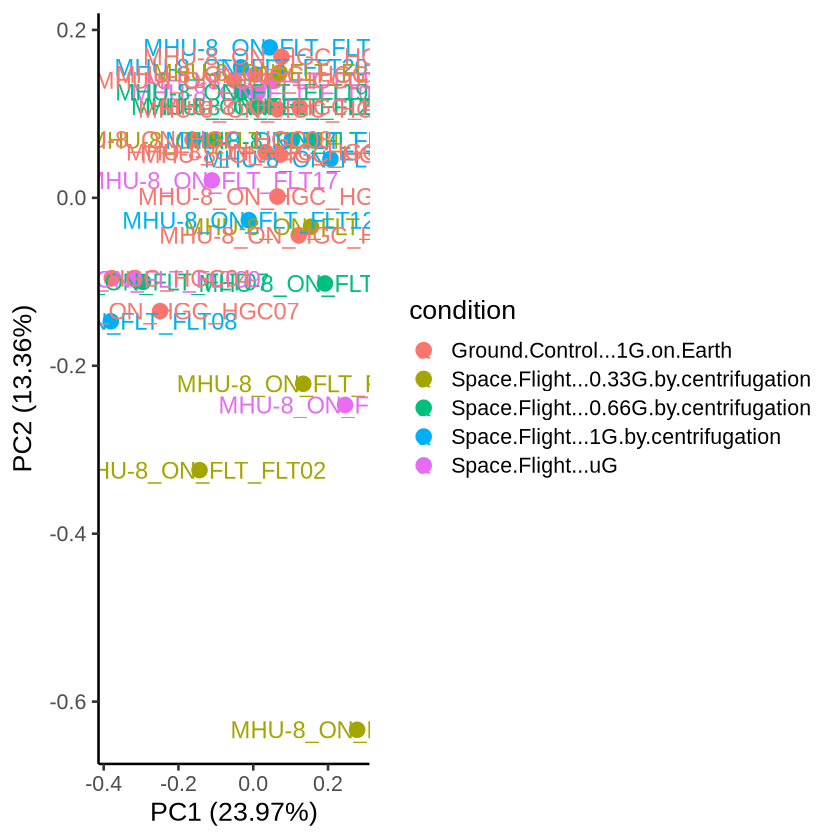

In [28]:
autoplot(PCA_raw, data=sampleTable, colour='condition', 
         label=TRUE, label.size=5, size=4, alpha=1) + theme_classic(base_size = 16)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `autoplot()` - a function from the **ggplot2** package (typically used for visualizing PCA results). It automatically generates a plot based on the input object, which in this case is our PCA result.
  
  - `PCA_raw` - This is the variable holding the **PCA object** that we generated above, which contains the principal components of the log2 transformed raw gene expression data. The first two principal components (PC1 and PC2) will be plotted on the x and y axes, respectively.

  - `data=sampleTable` - Specifies the sample metadata information storted in the `sampleTable` variable we created above.
  > This information will be used to color-code the samples based on which treatment group they belong to. 

  - `colour='condition'` - This argument specifies that the points (samples) in the PCA plot will be colored according to the "condition" column in `sampleTable`.

  - `label=TRUE` - Instructions the `autoplot()` function to label each point using the sample names specified in the `sampleTable`.

  - `label.size=5` - Specifies the size of the _labels_ displayed on the PCA plot to be 5.

  - `size=4` - Specifies the size of the _points_ on the PCA plot to be 4.

  - `alpha=1` - Sets the _transparency_ of the points. This is a value between 0 and 1 such that `alpha=1` means the points are fully opaque, whereas lower values (e.g., `alpha=0.5`) would make the points semi-transparent.

- `+ theme_classic(base_size = 16)`
  - `theme_classic()` is a **ggplot2** theme function that gives the plot a classic, clean look (removing gridlines and simplifying axes).
  - `base_size=16` sets the _base font size_ of the plot, making all text (axis titles, labels, etc.) size 16 font.
 
</div>


Let's save your PCA plot, with all samples labeled, to your PCA directory defined in [Step 2b](#2b.-Set-up-Directory-Path-Variables-in-R) above using the `ggsave()` function. 
> You can adjust the width, height, and dpi of the saved plot until you're satisfied with how the PCA plot looks. 

In [29]:
ggsave(file.path(pca_dir, paste(GLDS, "_PCA_raw_wlabels.png", sep="")), width = 8.5, height = 6, dpi = 300)

The PCA plot with all samples labeled is a bit messy, don't you think?

Let's create another plot without the sample labels by indicating that the label is FALSE instead of TRUE, and save this plot again using `ggsave()`:

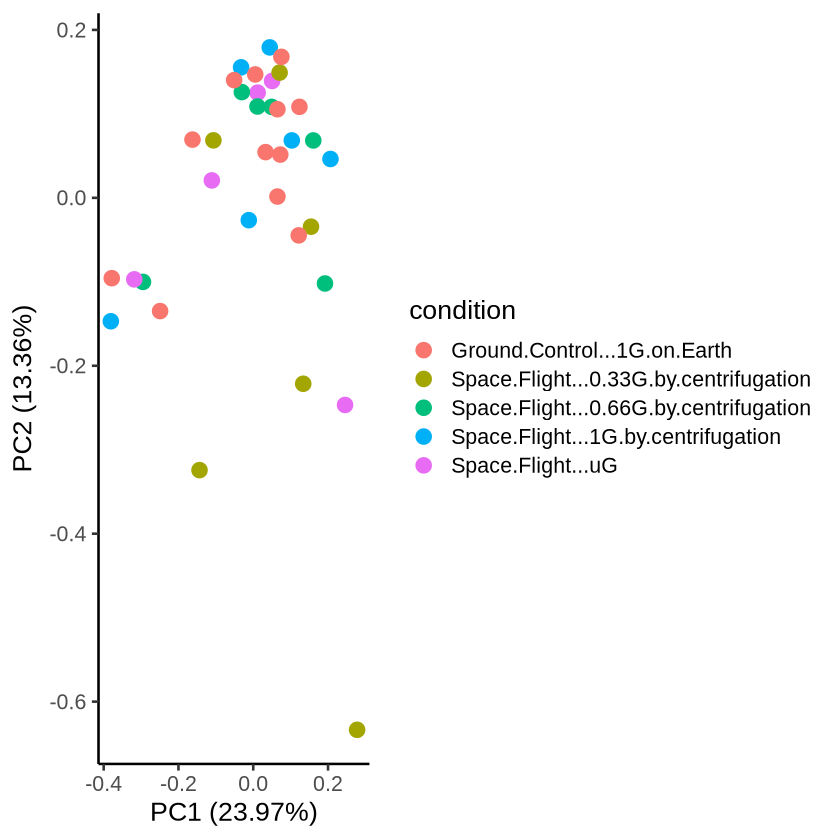

In [30]:
autoplot(PCA_raw, data=sampleTable, colour='condition', 
         label=FALSE, label.size=5, size=4, alpha=1) + theme_classic(base_size = 16)

## Save your PCA plot without sample labels
ggsave(file.path(pca_dir, paste(GLDS, "_PCA_raw_nolabels.png", sep="")), width = 8.5, height = 6, dpi = 300)

<div class="alert alert-block alert-info">
<b>Note:</b><br>

Now that you know how to create plots with and without labels indicated, for the remaining PCA plots, we will only show the cleaner plots (without samples labeled). If you want to know which dot represents which sample, you are welcome to change the label back to TRUE in any of the plots we generate below.

</div>

**Take a look at the PCA plots we generated using the log2 transformed raw counts data and answer the following questions:**

1. Is there a pattern in how the samples are separating? 

2. Would you expect the data points to separate like this based on their biological conditions? Why or why not?

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

This will depend on your dataset, but samples will separate by experimental group if indeed the different treatments in each group impact gene expression.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

If you anticipate that the different treatments impact gene expression than you would expect the point (representing samples) to separate by their experimental groups.

</details>
</div>

<br>

---

**We are now ready to begin the DESeq2 analysis, which is composed of 3 steps.**

<br>

<a class="anchor" id="sizefactor"></a>
## 3b. DESeq2 Step 1: Size Factor Estimation

In this first step, called size factor estimation, the algorithm corrects for the sample-wise differences in read depth.

The `estimateSizeFactors()` function provided by DESeq2 performs RNA-seq read depth normalization using the median of ratios method on the DESeqDataSet Object, `dds` that we made in [step 2e](#2e.-Make-DESeqDataSet-Object) above. 
> For additional information and training about the DESeq2 median of ratios method, visit [this HBC training](https://hbctraining.github.io/DGE_workshop/lessons/02_DGE_count_normalization.html).

<div class="alert alert-block alert-info">
<b>Median of ratios method</b><br>

1. A pseudo-reference sample is created for each gene, which is equal to the genometric mean of that gene's expression (count) across all samples.
2. For each gene in a sample, the gene expression for that sample is divided by the gene expression for the pseudo-reference sample to create a ratio (sample/pseudo-reference) for each gene in each sample.
3. The median value of all ratios for each sample is then extracted and used as the normalization factor (aka size factor) for that sample.
4. Lastly, each raw gene count value in each sample is divided by that sample's normalization factor to generate the normalized expression (count) values for all genes for all samples.

</div>

In [31]:
dds_1 <- estimateSizeFactors(dds)

using 'avgTxLength' from assays(dds), correcting for library size



<br>

<a class="anchor" id="dispersions"></a>
## 3c. DESeq2 Step 2: Estimate Gene Dispersions

Now that our count data are size-normalized, let's move on to the next step in the DESeq2 program: estimating gene dispersions then shrinking the gene-wise dispersion estimates toward the expected dispersion values.

The _dispersion_ of a gene is a measure of the spread or variability of that gene's expression in a dataset. We are interested in calculating the dispersion of each gene to understand whether there is unexpected variability in our dataset, which may be due to technical artifacts, and then correct for it.

`DESeq2` measures dispersion as it relates the mean and variance of the data such that DESeq2 dispersion estimates are inversely related to the mean and directly related to variance. Thus, the dispersion is higher for small mean counts and lower for large mean counts. 

The `estimateDispersions()` function provided by DESeq2 calculates the gene-wise dispersions and then shrinks them in order to model the size-normalized counts for each gene.
> For additional information and training on how DESeq2 estimates gene dispersions and performs skrinkage, visit [this HBC training](https://hbctraining.github.io/DGE_workshop/lessons/04_DGE_DESeq2_analysis.html).

<div class="alert alert-block alert-info">
<b>Estimate gene dispersions and perform skrinkage</b><br>

We first need to generate accurate estimates of within-group variation (i.e. variation between biological replicates of the same treatment group) for each gene. However, since there are a small number of replicates per group (6 in our dataset), the estimates of variation for each gene are often unreliable, especially for genes with smaller means (due to the large differences in dispersion for lower expressing genes). To address this issue, DESeq2 _shares information across genes_ to generate more accurate estimates of variation based on the mean expression level of the gene.
  > Using this approach, referred to as "shrinkage", DESeq2 assumes that genes with similar expression levels have similar dispersion/variance.

1. **Estimate gene-wise dispersion**: The dispersion for each gene is estimated using maximum likelihood estimation (MLE). This means that the most likely estimate of dispersion is calculated for each gene, given the gene expression values (aka gene counts) from all the replicates in each group.

2. **Generate estimation curve**: Next, the size-normalized count value of each gene is plotted against the MLE of the dispersion for that gene for all genes in all sample groups. The values on that plot are used to generate a curve that represents the estimate for the expected dispersion value for genes of a given expression strength (count value).

3. **Shrink gene-wise dispersion estimates**: Finally, the gene-wise dispersion estimates are shrunk towards the expected dispersion values predicted by the curve.
  > The strength of the shrinkage for each gene depends on:
  > - how close the gene dispersion is from the curve
  > - sample size (more samples = less shrinkage)

Genes with low dispersion estimates are shrunken towards the curve and genes with dispersion estimates slightly above the curve are also shrunked towards the curve for better dispersion estimation of these genes. However, genes with extremely high dispersion values are not shrunken because these genes likely do not follow the DESeq2 modeling assumptions and have higher variability than the others for biological or technical reasons.
> Note: Shrinking these values toward the curve could result in false positives, which is why they are not shrunken. _These exceptionally high variability genes are shown as black dots surrounded by blue circles in the plot we will look at below._
 
**This shrinkage method is particular important to reduce false positives in the DGE analysis we will perform below.**

</div>


In [32]:
dds_1 <- estimateDispersions(dds_1)

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



<br>

**Visualize gene-wise dispersion estimates**

Let's take a look at the relationship between the expression of each gene and the gene dispersion estimates we calculated above by plotting these values with the `plotDispEsts()` function: 

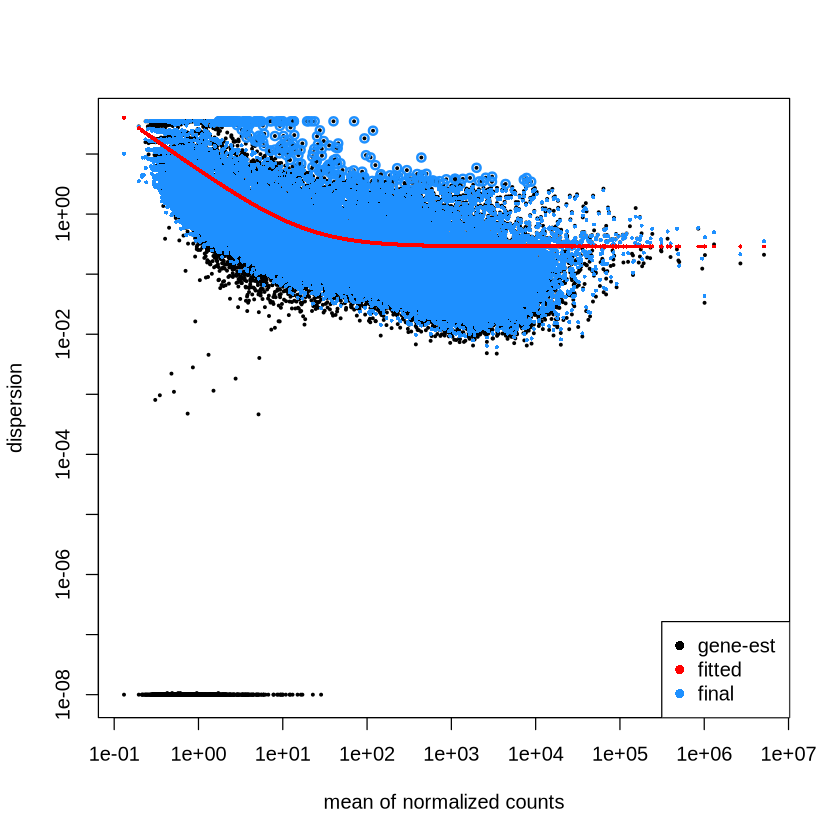

In [33]:
plotDispEsts(dds_1)

**Use the plot above to answer the following questions:**

1. What is the relationship between gene dispersion and mean expression of a gene? What does this tell you about RNA sequencing data? 
2. How do the gene expression data change before (black dots) and after (blue dots) fitting gene dispersion estimates using the skrinkage method?

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

As gene expression (counts shown on the x-axis) increases, dispersion (on the y-axis) decreases.

This tells us that RNAseq data are noisy for low expressing genes.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The dispersion of the gene expression data gets closer to the expected dispersion value for each gene expression level after shrinkage.

</details>
</div>

<br>

---


<br>

<a class="anchor" id="wald"></a>
## 3d. DESeq2 Step 3: Hypothesis Testing with Wald Test

Finally, we are ready to proceed to the third and final step of the DESeq2 process, hypothesis testing. Hypothesis testing will tell us the probability of each gene's expression being significantly different in one or more treatment groups.

We will perform our hypothesis testing using the Wald test, which is similar to a T-test. Recall from the "GL4U RNAseq Statistics Overview" lecture that the Wald test needs to know the type of data distribution to use to build a mathematical model suitable for hypothesis testing. RNAseq data most closely mimics a negative bionomial distribution, where the majority of genes have an expression value close to zero with some genes having higher expression values.

Therefore, we will use the `nbinomWaldTest()` function provided by DESeq2 to fit a negative binomial model to the gene expression data and perform hypothesis testing using the Wald test. 

<div class="alert alert-block alert-info">
<b>Negative binomial Wald test</b><br>

The DESeq2 `nbinomWaldTest()` function will calculate a Wald statistic for each gene as shown below, along with a probability value (p-value) of the test. If the p-value is small, we reject the null hypothesis and state that there is evidence against the null (i.e. the gene is differentially expressed).
> Note: The null hypothesis we are testing is that the gene does not change expression significantly between the two groups.

$$
W = \frac{\hat{\beta}}{\text{SE}(\hat{\beta})}
$$

Where:
- $W$: The Wald statistic
- $\hat{\beta}$: The estimated log2 fold change (LFC) for the gene between the two conditions (e.g. FLT and GC).
- $\text{SE}(\hat{\beta})$: The standard error of the LFC estimate calculated as follows:
  $$
  \text{SE}(\hat{\beta}) = \sqrt{\text{Var}(\hat{\beta})}
  $$
  Where:
  - $\text{Var}(\hat{\beta})$ is the estimated variance of the LFC.
  
</div>

**Multiple tests correction**

Recall from the "GL4U RNAseq Statistics Overview" lecture that the more genes we test, the more we inflate the false positive rate, which is know as the multiple testing problem. 
> E.g. If we test 20,000 genes for DE defined as p < 0.05, we would expect to find 1,000 genes by chance. If we found 2,000 DEGs in total, about one half of our genes are likely false positives.

To reduce the number of false positives, in DESeq2, the p-values attained by the Wald test are corrected for multiple testing using the Benjamini and Hochberg (BH) method, by default, to generate an adjusted p-value for each gene. 
> **The adjusted p-values should be used to determine significant DEGs.**

<div class="alert alert-block alert-info">
<b>BH method to adjust for FDR</b><br>

In DESeq2, the BH method for controlling the FDR is implemented by ranking the genes by p-value then multipying each ranked p-value by the ratio of the number of genes tested divided by the rank for that gene, as shown below:

$$
\text{Adjusted p-value} = \text{p-value} \times \frac{m}{\text{rank}}
$$

Where:
- $m$: The total number of genes (i.e. total tests).
- $\text{rank}$: The rank of the gene's p-value after sorting the genes by their p-values.

</div>

In [34]:
dds_1 <- nbinomWaldTest(dds_1)

Run the following command to store the normalized gene counts as a matrix represented by the variable `normCounts`:

In [35]:
normCounts <- as.data.frame(counts(dds_1, normalized=TRUE))

**Answer the following questions:**

1. Is the Wald test the only type of hypothesis testing method we could have used here? (Hint: see the "Likelihood ratio test" section here: http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)
   
2. Why did we choose the Wald test?

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

No, the Wald test is not the only type of hypothesis testing method we could have used. The likelihood ratio test (LRT) is another option.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

We choose to use the Wald test because we are comparing two groups.

</details>
</div>

<br>

<div class="alert alert-block alert-info">
<b>Note:</b><br>

Although we do not calculate the likelihood ratio test (LRT) in this tutorial, since there are several RNAseq datasets on OSDR that contain more than 2 groups, the current GeneLab pipeline also runs the LRT to generate the F-statistic p-value, which is similar to the an ANOVA p-value, and the F-statistic adjusted p-value. 
> _Only the F-statistic adjusted p-value is reported in the "LRT.p.value" column of the GeneLab differential_expression.csv file._

</div>

<br>


#### DESeq2 Likelihood ratio test (LRT)

Run the following code block to run the DESeq2 LRT on your data, save the output in the `dds_1_lrt` variable, then store the results of the analysis in the `res_1_lrt` variable:


In [36]:
dds_1_lrt <- DESeq(dds_1, test = "LRT", reduced = ~ 1)
res_1_lrt <- results(dds_1_lrt)

using pre-existing normalization factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 690 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



---

#### **PCA of normalized count data**

Now that we've normalized our count data, let's perform principal component analysis (PCA) of our normalized count data using the commands described in [step 3a](#3a.-PCA-of-Raw,-Unnormalized-Count-Data) above.

We'll start by log2 transforming our normalized count data then we'll calculate the principal components:

In [37]:
## Add 1 to every gene count then log2 transform the normalized counts data ##
exp_norm <- log2(normCounts+1)

## Calculate the principal components of the normalized counts data ##
PCA_norm <- prcomp(t(exp_norm), scale = FALSE)

We're now ready to plot PC1 vs. PC2 (without labels) then save our plot with `ggsave()`:

In [ ]:
autoplot(PCA_norm, data=sampleTable, colour='condition', 
         label=FALSE, label.size=5, size=4, alpha=1) + theme_classic(base_size = 16)

## Save your PCA plot without sample labels
ggsave(file.path(pca_dir, paste(GLDS, "_PCA_norm_nolabels.png", sep="")), width = 8.5, height = 6, dpi = 300)

**Look at the PCA plots before and after normalization, and answer the following questions:**

1. Is the percent of variance explained by PC2 more or less after normalization? Does that tell you anything about what was contributing to the differences in PC2?
   
2. How has the within-group variation changed? Why do you think that is?
   
3. How has the percent of variance explained by PC1 changed? What does this mean? 

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

This will depend on the dataset you're analyzing. If the raw count data showed samples separating by treatment group in PC1 and PC2 likely accounted for technical differences between samples, then the percent of variance explained by PC2 would be less after normalization.

This would suggest that some of the differences among samples observed in the raw count data were driven by technical differences between samples that have been corrected for upon normalization.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

This will depend on the dataset you're analyzing. If the raw count data showed samples separating by treatment group in PC1 and PC2 likely accounted for technical differences between samples, then the within group variation will now be smaller, i.e. the samples within each treatment group are closer together than they were using the raw count data.

This would suggest that some of the differences among samples within the same group were due to technical artifacts.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

This will depend on the dataset you're analyzing. If the raw count data showed samples separating by treatment group in PC1 and PC2 likely accounted for technical differences between samples, then the percent of variance explained by PC1 would have increased.

This would suggest that the differences explained by PC1, which appears to represent the biological signal (i.e. the differences between the treatment groups) became stronger after normalizing for technical differences. 

</details>
</div>


<br>

---

**Challenge:** Use the next few code blocks to 1) list the number of PCs after normalization and 2) recreate the PCA plot but adjust these parameters: label.size, size, alpha (must be between 0 and 1). How does your plot change?
> Hint: 1) Use the `summary()` function we used in step 3a. 2) Fist copy the `autoplot()` command from the previous code block then change the parameters.

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

```R
autoplot(PCA_norm, data=sampleTable, colour='condition', 
         label=FALSE, label.size=5, size=8, alpha=0.3) + theme_classic(base_size = 16) 
```

The size of the dots changed and became more transparent.

</details>
</div>

<br>

---

<a class="anchor" id="dge"></a>
# 4. DGE Analysis
> **Required kernel:** R

The results of the DESeq2 analysis we performed in [step 3](#3.-DESeq2-Analysis) are currently stored in the `dds_1` object. In the next steps, we will create a differential gene expression (DGE) output table and use the `results()` function to extract the DESeq2 results and add them to the table. We will start with our normalized counts table generated at the end of [Step 3d](#3d.-DESeq2-Step-3:-Hypothesis-Testing-with-Wald-Test) above and add pair-wise comparison columns containing the group 1 vs group 2 statistical data from the Wald tests performed in [Step 3d](#3d.-DESeq2-Step-3:-Hypothesis-Testing-with-Wald-Test). We will also perform calculations to generate columns containing all samples as well as group means and standard deviations and complete the table by adding gene annotations. 

<a class="anchor" id="calculations"></a>
## 4a. Perform Data Calculations and Create DGE Output Table

**Create DGE output table**

We'll start the DGE output table, held in the variable `DGE_output_table`, by adding the normalized gene count data from each sample created in [step 3d](#3d.-DESeq2-Step-3:-Hypothesis-Testing-with-Wald-Test):  

In [ ]:
DGE_output_table <- normCounts 

Take a look at the first 6 rows of our initial DGE table. 

In [ ]:
options(repr.matrix.max.cols=150)
head(DGE_output_table)

<div class="alert alert-block alert-info">
<b>Note:</b><br>

The DGE output table currently has 1 column for each sample, and the rows are genes (shown here as ENSEMBL or TAIR  IDs for animals or plants, respectively).

</div>


**Add pairwise comparison columns**

Next we'll iterate through the results of the Wald tests to generate pairwise comparison columns for each contrast listed in our `contrasts` table.

Let's first take a look at the contrasts we set up at the end of [step 2c](#2c.-Import-and-Format-Sample-Metadata-in-R):

In [ ]:
contrasts

We want to iterate through each contrast shown above and report the log2 fold change, Wald statistic, p-value, and adjusted p-value from the Wald Tests we performed in [Step 3d](#3d.-DESeq2-Step-3:-Hypothesis-Testing-with-Wald-Test).

In [ ]:
for (i in 1:dim(contrasts)[2]){
   res_1 <- results(dds_1, contrast=c("condition",contrasts[1,i],contrasts[2,i]))  
	res_1 <- as.data.frame(res_1@listData)[,c(2,4,5,6)]  
	colnames(res_1) <-c(paste0("Log2fc_",colnames(contrasts)[i]),
                        paste0("Stat_",colnames(contrasts)[i]),
                        paste0("P.value_",colnames(contrasts)[i]),
                        paste0("Adj.p.value_",colnames(contrasts)[i]))  
	DGE_output_table <- cbind(DGE_output_table,res_1)  
}

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `for (i in 1:dim(contrasts)[2]){}`:  
  - This is a _for loop_ that iterates over each column of the `contrasts` matrix.
  - `dim(contrasts)[2]` returns the number of columns in the `contrasts` matrix, meaning the loop will iterate from 1 to the total number of contrasts.
  - **`i`** represents the index of the current contrast column being processed.

- `res_1 <- results(dds_1, contrast=c("condition", contrasts[1,i], contrasts[2,i]))`:  
  - This line uses the `results()` function from DESeq2 to obtain the differential expression results for a specific contrast.
  - `dds_1`: The DESeqDataSet object that contains the DESeq2 results.
  - `contrast=c("condition", contrasts[1,i], contrasts[2,i])`: This specifies the contrast for the condition being tested. It extracts the values from the `contrasts` matrix for the current iteration, where:
    - `contrasts[1,i]`: The first level of the condition being compared.
    - `contrasts[2,i]`: The second level of the condition being compared.
  - The `results()` function returns an object containing p-values, log2 fold changes, and other statistical results that is stored in the `res_1` variable.

- `res_1 <- as.data.frame(res_1@listData)[,c(2,4,5,6)]`:  
  - Converts the `results` object (which is an S4 object) to a _data frame_ by accessing its `listData` slot.
  - `[,c(2,4,5,6)]`: Selects specific columns from the `listData`, which are:
    - Column 2: Log2 fold change (log2FC).
    - Column 4: Wald statistic (Stat).
    - Column 5: Raw p-value (P.value).
    - Column 6: Adjusted p-value (Adj.p.value).

- `colnames(res_1) <- c(paste0("Log2fc_", colnames(contrasts)[i]), paste0("Stat_", colnames(contrasts)[i]), paste0("P.value_", colnames(contrasts)[i]), paste0("Adj.p.value_", colnames(contrasts)[i]))`:  
  - Renames the columns in `res_1` using the `paste0()` function, which concatenates strings.
  - The column names for each result are customized based on the contrast currently being evaluated (`colnames(contrasts)[i]`). For example:
    - `"Log2fc_"` will be followed by the name of the contrast for that column.
    - `"Stat_"`, `"P.value_"`, and `"Adj.p.value_"` follow the same pattern for the corresponding statistics.

- `DGE_output_table <- cbind(DGE_output_table, res_1)`:  
  - `cbind()` (column bind) appends the results (`res_1`) as new columns to the existing DGE output table (`DGE_output_table`).

> Note: The loop will iteratively add new sets of results for each contrast, appending them as additional columns to the `DGE_output_table`.

</div>

<br>

**Add all mean and standard deviation columns**

For each gene, we will calculate the mean expression and standard deviation across all samples and add these calculations to the DGE output table.

In [ ]:
DGE_output_table$All.mean <- rowMeans(normCounts, na.rm = TRUE, dims = 1)
DGE_output_table$All.stdev <- rowSds(as.matrix(normCounts), na.rm = TRUE, dims = 1)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `DGE_output_table$All.mean <- rowMeans(normCounts, na.rm = TRUE, dims = 1)`:
  - `DGE_output_table$All.mean`: This creates a new column in the `DGE_output_table` data frame called `All.mean`, which will store the mean of each row (gene) across all samples.
  - `rowMeans(normCounts, na.rm = TRUE, dims = 1)`:
    - `rowMeans()`: A base R function that calculates the _mean_ for each row in a matrix or data frame.
    - `normCounts`: This is the matrix that contains the normalized counts for each gene (rows) across all samples (columns).
    - `na.rm = TRUE`: Specifies that missing values (`NA`) should be removed before calculating the means.
      > _Note: If this is set to `FALSE`, the presence of `NA` values would cause the mean to return `NA`._
    - `dims = 1`: This specifies that the function should calculate means along rows (genes), not columns.
      > _Note: In `rowMeans()`, `dims = 1` is the default and ensures the function operates row-wise._

- `DGE_output_table$All.stdev <- rowSds(as.matrix(normCounts), na.rm = TRUE, dims = 1)`:
  - `DGE_output_table$All.stdev`: This creates a new column in the `DGE_output_table` data frame called `All.stdev`, which will store the standard deviation of each row (gene) across all samples.
  - `rowSds(as.matrix(normCounts), na.rm = TRUE, dims = 1)`:
    - `rowSds()`: A function from the _matrixStats_ package that calculates the _standard deviation_ for each row in a matrix.
    - `as.matrix(normCounts)`: Converts the `normCounts` object into a matrix (if it is not already a matrix) because the `rowSds()` function requires a matrix as input.
    - `na.rm = TRUE`: Ensures that any missing values (`NA`) are removed before calculating the standard deviation.
    - `dims = 1`: This specifies that the function should calculate standard deviations along rows (genes), which is the default for `rowSds()`.

</div>

<br>

**Challenge:** Use the code block below to look at the first 6 rows of the DGE output table now. 

> Hint: Use the head() function we used at the beginning of this step (4a).

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

```R
head(DGE_output_table)
```

</details>
</div>

<br>

**Look at the DGE output table now and answer the following questions:**
1. How many columns have been added?
  
2. What is the average expression of the first gene listed across all samples?

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The number of columns that have been added is equal to 4 * [Number of contrasts] + 2. 4 because there are 4 results columns (log2 fold change, Wald statistic, p-value, and adjusted p-value) added per contrast plus the `All.mean` and `All.stdev` columns we just added.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The average expression of the first gene listed will be the value in the `All.mean` column associated with the first gene listed. 

</details>
</div>

<br>

**Add the DESeq2 LRT value:**

If you calculated the DESeq2 LRT value for these data in [step 3d](#DESeq2-Likelihood-ratio-test-(LRT)) above, you can add the F statistic p-value (similar to ANOVA p-value) generated from the LRT to the DGE output table by running the following command:


In [ ]:
DGE_output_table$LRT.p.value <- res_1_lrt@listData$padj

<br>

**Add group mean and standard deviation columns**

Next, we'll calculate the mean expression for each gene across samples within each group, and add group means to the `DGE_output_table`.
> Note: This can take several minutes depending on how many sample groups are in your dataset.

In [ ]:
tcounts <- as.data.frame(t(normCounts))
tcounts$group <- group
group_means <- as.data.frame(t(aggregate(. ~ group,data = tcounts,mean)))
group_means <- group_means[-c(1),]
colnames(group_means) <- paste0("Group.Mean_",levels(factor(names(group))))

DGE_output_table <- cbind(DGE_output_table,group_means)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `tcounts <- as.data.frame(t(normCounts))`:  
  - `t(normCounts)`: Transposes the `normCounts` matrix so that rows become columns and columns become rows.
    > - _Before transposing_: Rows represent genes and columns represent samples.
    > - _After transposing_: Rows now represent samples, and columns represent genes.
  - `as.data.frame()`: Converts the transposed matrix into a data frame called `tcounts`, so it can be manipulated more easily in subsequent steps.

- `tcounts$group <- group`:  
  - Adds a new column titled "group" to the `tcounts` data frame, that specifies which group each sample belongs to using the `group` variable created in [step 1b](#1b.-Import-the-Data) above.

- `group_means <- as.data.frame(t(aggregate(. ~ group, data = tcounts, mean)))`:  
  - `aggregate(. ~ group, data = tcounts, mean)`: Calculates the _mean_ of each gene for each group in `tcounts`:
    - `~ group`: Specifies that the data should be grouped by the `group` variable.
    - `.`: Refers to all other columns (genes) in `tcounts`.
    - `mean`: Computes the mean of each gene for each group.
  - `t()`: Transposes the resulting data frame (so that the group means for each gene are in columns, with rows representing genes).
  - `as.data.frame()`: Converts the transposed matrix into a data frame called `group_means`.

- `group_means <- group_means[-c(1),]`:  
  - Removes the first row from the `group_means` data frame, which is the `group` row created by the `aggregate()` function (which serves as metadata rather than gene data).
  - `[-c(1),]`: This removes the first row, keeping the remaining rows (gene expression means for each group).

- `colnames(group_means) <- paste0("Group.Mean_", levels(factor(names(group))))`:  
  - Renames the columns in `group_means` to reflect the group each mean belongs to:
    - `paste0("Group.Mean_", levels(factor(names(group)))`: Creates new column names by concatenating `"Group.Mean_"` with the group names.
    - `levels(factor(names(group)))`: Extracts the group names from the `group` variable.


- `DGE_output_table <- cbind(DGE_output_table, group_means)`:  
  - `cbind()`: Column-binds the `group_means` data frame to the `DGE_output_table`, adding the group-wise gene means as new columns in the DGE output table.

</div>

<br>

Now, we'll calculate the standard deviation for each gene across samples within each group, and add group standard deviations to the `DGE_output_table`.

In [ ]:
group_stdev <- as.data.frame(t(aggregate(. ~ group,data = tcounts,sd)))
group_stdev <- group_stdev[-c(1),]
colnames(group_stdev) <- paste0("Group.Stdev_",levels(factor(names(group))))

DGE_output_table <- cbind(DGE_output_table,group_stdev)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `group_stdev <- as.data.frame(t(aggregate(. ~ group, data = tcounts, sd)))`:  
  - This command is similar to the one above, but instead of calculating the mean, it calculates the _standard deviation_ (`sd`) of each gene for each group.
  - `aggregate(. ~ group, data = tcounts, sd)`: Aggregates the data by `group` and calculates the standard deviation for each gene.
  - `as.data.frame(t())`: Transposes and converts the result into a data frame called `group_stdev`.

- `group_stdev <- group_stdev[-c(1),]`:  
  - Removes the first row of the `group_stdev` data frame, similar to how it was done for `group_means`, since the first row is the metadata for `group`.

- `colnames(group_stdev) <- paste0("Group.Stdev_", levels(factor(names(group))))`:  
  - Renames the columns in `group_stdev` to reflect the group each standard deviation belongs to:
    - `paste0("Group.Stdev_", levels(factor(names(group)))`: Creates new column names by concatenating `"Group.Stdev_"` with the group names.


- `DGE_output_table <- cbind(DGE_output_table, group_stdev)`:  
  - `cbind()`: Similarly, column-binds the `group_stdev` data frame to the `DGE_output_table`, adding the group-wise gene standard deviations as new columns.

</div>

<br>

**Use the code block below to look at the first few rows of the DGE output table now and answer the following question:** 

1. How many columns have been added?

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The number of columns that have been added to the DGE table is equal to 2 * [Number of groups], one new column for the group mean and one for the standard deviation per group.

</details>
</div>

<br>

---

<a class="anchor" id="annotations"></a>
## 4b. Add Gene Annotations 

Looking at the first column of our DGE table above, you'll notice that the genes are listed as ENSEMBL or TAIR gene IDs (for animal or plant datasets, respectively), which doesn't really mean much to anyone unless you have a list of which gene each ENSEMBL or TAIR ID represents. Since gene names can be long, it may also be useful to know which gene symbol corresponds to each ENSEMBL or TAIR ID. Furthermore, depending on what downstream analyses you want to run, having a list of IDs from other databases such as RefSeq, Entrez, and/or GOSLIM may be required. Therefore, in this step, we will run a series of commands to add columns to our DGE output table containing other gene identifiers that correspond to the respective ENSEMBL or TAIR ID.

**Import the GeneLab Reference Annotation Table**

<div class="alert alert-block alert-info">
<b>Note:</b><br>

GeneLab has created annotation tables for a variety of model organisms used in studies hosted on the [OSDR](https://osdr.nasa.gov/bio/repo). The links to the annotation tables for specific organisms are indicated in the [GL-DPPD-7110-A_annotations.csv](https://github.com/nasa/GeneLab_Data_Processing/blob/master/GeneLab_Reference_Annotations/Pipeline_GL-DPPD-7110_Versions/GL-DPPD-7110-A/GL-DPPD-7110-A_annotations.csv) file located in the [GeneLab Reference Annotations directory on GitHub](https://github.com/nasa/GeneLab_Data_Processing/tree/master/GeneLab_Reference_Annotations). 

Check the Ensembl version used to align the data in your dataset, which can be found under "GeneLab RNAseq data processing protocol" in the Protocols section on [OSDR](https://osdr.nasa.gov/bio/repo/). If it is not consistent with the Ensembl version listed in the [GL-DPPD-7110-A_annotations.csv](https://github.com/nasa/GeneLab_Data_Processing/blob/master/GeneLab_Reference_Annotations/Pipeline_GL-DPPD-7110_Versions/GL-DPPD-7110-A/GL-DPPD-7110-A_annotations.csv) table, replace the link to that table file with the GeneLab Reference Annotation version consistent with your processed dataset. 

</div> 

Run the following code block to retrieve the link to the annotation table for the organism used in your select study, then read in the annotation table:
> Note: The organism used is identified from the \*runsheet.csv file you created in [Step 1b](#1b.-Download-and-Format-the-Metadata).

In [ ]:
## Create a function to identify the GeneLab annotations table link for a give organism ##
fetch_organism_specific_annotation_file_path <- function(organism) {
  all_organism_table <- read.csv("https://raw.githubusercontent.com/nasa/GeneLab_Data_Processing/refs/heads/master/GeneLab_Reference_Annotations/Pipeline_GL-DPPD-7110_Versions/GL-DPPD-7110-A/GL-DPPD-7110-A_annotations.csv")
  annotations_link <- all_organism_table %>% dplyr::filter(species == organism) %>% dplyr::pull(genelab_annots_link)
  # Generate an error message if the organism does not have an associated annotation file yet
  if (length(annotations_link) == 0) {
    stop(glue::glue("Organism supplied '{organism}' is not supported. See the following url for supported organisms: https://github.com/nasa/GeneLab_Data_Processing/blob/master/GeneLab_Reference_Annotations/Pipeline_GL-DPPD-7110_Versions/GL-DPPD-7110-A/GL-DPPD-7110-A_annotations.csv.  Supported organisms will correspond to a row based on the 'species' column and include a url in the 'genelab_annots_link' column of that row"))
  }
  return(annotations_link)
}

## Use the function above to specify the GeneLab annotations table link for your organism, defined in the runsheet ##
df_rs = read.csv(runsheet_path)
annotations_link <- fetch_organism_specific_annotation_file_path(unique(df_rs$organism))

## Read in the GeneLab annotation table for your organism of interest ##
annot <- read.table(annotations_link, sep = "\t", header = TRUE, quote = "", comment.char = "", row.names = 1)

---

**Challenge:** Use the following code block to view the first row of our Gene Annotation table, `annot`.
> Hint: Use the `head()` function. Don't forget to define the number of rows with `n= `.

**Looking at the first row of the Gene Annotations table above, answer the following questions:**

1. How many different types of gene annotations does the table contain?
2. What is the gene name and symbol of the first gene shown?
3. How many biological functions involve the first gene shown?
   > _**Hint**_: Use the techniques we learned in the R intro JN and the code block below to slice out the first row of the `GOSLIM_IDS` column.

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

```R
head(annot, n=1)  
```

Depending on the organism your samples are derived from, there will be up to 7 annotation columns, including the ENSEMBL or TAIR IDs for animal and plant species, respectively. 

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The gene name of the first gene shown can be found under the "GENENAME" column in the first row, and the gene symbol can be found under the "SYMBOL" column. 
> *Note: If the first gene shown is an unannotated gene, there may not be a gene name or symbol.*  

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

```R
annot[1,"GOSLIM_IDS"] 
```

<br>

The number of (known) biological functions that involve the first gene shown is equal to the number of "GO" terms listed in the `GOSLIM_IDs` column for that gene. 
> *Note: If the first gene shown is an unannotated gene, there may not be any known biological functions.*

</details>
</div>

<br>

**Add gene annotations to the DGE table**

We're now ready to combine our Gene Annotation table, `annot`, with the DGE output table, `DGE_output_table`, that we generated in [Step 4a](#4a.-Perform-Data-Calculations-and-Create-DGE-Output-Table) to create the final DGE output table:
> Note: If you're working with a plant dataset, replace `ENSEMBL` with `TAIR` in the code block below. 

In [ ]:
DGE_output_table <- merge(annot, DGE_output_table, by='row.names', all.y=TRUE)

## Add a column name to the first row specifying the IDs used ##
DGE_output_table <- DGE_output_table %>% 
  rename(
    ENSEMBL = Row.names ## Change ENSEMBL to TAIR for plant studies ##
  )

Take a look at the first row of the final DGE output table:
> _Note: Each row of the DGE output table contains data for one gene._

In [ ]:
options(repr.matrix.max.cols=150)
head(DGE_output_table, n=1) # Scroll to the right to see all the columns we've added

<div class="alert alert-block alert-info">
<b>DGE output table content</b><br>

The DGE output table contains the following columns:
> _Note: Depending on the organism for your dataset, the some annotation columns may be different or incomplete. See the GeneLab Reference Annotations pipeline, [GL-DPPD-7110-A](https://github.com/nasa/GeneLab_Data_Processing/blob/master/GeneLab_Reference_Annotations/Pipeline_GL-DPPD-7110_Versions/GL-DPPD-7110-A/GL-DPPD-7110-A.md) for more info._

* **ENSEMBL**, **SYMBOL**, **GENENAME**, **REFSEQ**, **ENTREZID** - these are all various types of gene IDs

* **STRING_id** - the protein ID for the STRING database, used to identify protein-protein interactions

* **GOSLIM_IDs** - all gene ontology IDs for functional gene sets to which each gene belongs

* A column for each sample in your dataset containing the respective normalized counts for each gene 

* **Log2fc(group 1)v(group 2)**, **Stat_(group 1)v(group 2)**, **P.value_(group 1)v(group 2)**, **Adj.p.value_(group 1)v(group 2)** - log2 fold change, wald statistic, pvalue, and adjusted pvalue for the Wald test comparison of the group 1 samples vs. the group 2 samples
> _Note that the GeneLab standard pipeline runs all pairwise analyses for all group comparisons in both directions, so these values are also present for every possible group comparison in both the forward and reverse directions, e.g. (group 2)v(group 1)._
> 
> Notes regarding p-values set to NA:
> - If a row contains a sample with an extreme count outlier then the p-value and adjusted p-value will be set to NA. These outlier counts are detected by Cook’s distance.
> - If a row is filtered by automatic independent filtering, for having a low mean normalized count, then only the adjusted p-value will be set to NA because it could be a false positive.

* **All.mean**, **All.stdev**, **LRT.p.value** - mean, standard deviation, and F-statistic adjusted p-value for the LRT of each gene across all samples. 

* **Group.Mean_(group 1)**, **Group.Mean_(group 2)**, ..., **Group.Stdev_(group 1)**, **Group.Stdev_(group 2)**, ... - mean and standard deviation within each group in your select dataset.

</div>

<br>

**Save the contrasts and DGE tables**

The last step of the DGE analysis is to save the tables containing the sample grouping, the contrasts we used for DGE analysis, and our final DGE table using the `write.csv()` function.

In [ ]:
write.csv(sampleTable,file.path(DGE_output, "SampleTable.csv"))
write.csv(contrasts,file.path(DGE_output, "contrasts.csv"), row.names=FALSE)
write.csv(DGE_output_table,file.path(DGE_output, "differential_expression.csv"), row.names=FALSE)

<br>

---

<a class="anchor" id="vis"></a>
# 5. DGE Data Visualization
> **Required kernel:** R

It's time to visualize our data by generating some common gene expression visualization plots :0) 

First we'll generate log transformations of the normalized expression data and store them in the `exp_norm` variable:

In [ ]:
exp_norm <- log2(normCounts+1)

Next, we'll list the exact group names in our dataset by listing the column headers of the `contrasts` table. We'll then use these names to define the pairwise comparison to use for our data visualizations.

In [ ]:
cat(unique(gsub("\\(|\\)", "", sub("v.*", "", colnames(contrasts)))), sep = "\n")

Define which group comparison you want to visualize by replacing `g1` and `g2` with the respective group names from the list above:

In [ ]:
g1="Space Flight"
g2="Ground Control"

If there is a `/` in a group name, replace `/` with `-` to allow the output files to be saved in the correct location:

<div class="alert alert-block alert-info">
<b>Recall:</b><br>

`/` are special in R because they specify a new directory so if a `/` is in the file name, the R save functions below will mistake the `/` for a new directory.

</div> 


In [ ]:
g1mod <- gsub("/", "-", g1)
g1mod
g2mod <- gsub("/", "-", g2)
g2mod

Next, we'll create a filtered DGE table containing only significantly DEGs: 
> _**Note**_: We are considering DEGs with an adjusted p-value < 0.05 and |Log2 fold change| > 1 as significant. 

In [ ]:
dge_p <- DGE_output_table %>% dplyr::filter( !!rlang::sym(paste0("Adj.p.value_(",g1,")v(",g2,")")) < 0.05) # filter by adj p-value
dge_p_flc_up <- dge_p %>% dplyr::filter( !!rlang::sym(paste0("Log2fc_(",g1,")v(",g2,")")) > 1) # filter by lfc > 1
dge_p_flc_down <- dge_p %>% dplyr::filter( !!rlang::sym(paste0("Log2fc_(",g1,")v(",g2,")")) < -1) # filter by lfc < -1
dge_full <- rbind(dge_p_flc_up, dge_p_flc_down) # merge together

dge_p_flc <- dge_full[rowSums(is.na(dge_full)) != ncol(dge_full), ] # remove rows with NA

**Challenge:** 

Use the following code blocks to look at the dimensions of our DGE table before and after filtering: 

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

**Before filtering:**

```R
dim(DGE_output_table)
```

**After filtering:**

```R
dim(dge_p_flc)
```


</details>
</div>

<br>



**Use the filtered DGE table to answer the following questions:**

1. Why did we use the adjusted p-value to determine significance rather than the p-value?
   
2. How many significant DEGs are there?
   > _Hint: Look at the dimensions of the matrix (reported in rows by columns, or genes by samples)._
 
3. Based on the adjusted p-value cutoff used, how confident are we (in %) that those genes are DE?

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

We used the adjusted p-value to determine significance rather than the p-value because we performed multiple comparisons (over 20k genes, aka variables) testing and therefore need to use the adjusted p-value, which corrects for false discovery rate (FDR).

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The number of significant DEGs will depend on your dataset and the comparison you are looking at. The number of significant DEGs will be equal to the number of rows in your filtered table, `dge_p_flc`.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

We are 95% confident that those genes are DE. 

</details>
</div>

<br>

We'll now use the ENSEMBL IDs of our DEGs to subset our log2 transformed normalized counts matrix, `exp_norm`, and create a log2 transformed normalized counts matrix containing only DEGs: 
> _**Note:**_ If you're working with a plant dataset, replace `ENSEMBL` with `TAIR` in the code block below. 

In [ ]:
exp_dge <- exp_norm[dge_p_flc$ENSEMBL,] ## Change ENSEMBL to TAIR for plant studies ##
dim(exp_dge)

<br>

---

<a class="anchor" id="pca"></a>
## 5a. PCA

Let's perform another Principal Component Analysis similar to those in steps [3a](#3a.-PCA-of-Raw,-Unnormalized-Count-Data) and [3d](#3d.-DESeq2-Step-3:-Hypothesis-Testing-with-Wald-Test) but this time using only the significant DEGs:

In [ ]:
## Calculate the principal components of the normalized counts data ##
PCA_dge <- prcomp(t(exp_dge), scale = FALSE)

In [ ]:
## Create your PCA plot without samples labeled
autoplot(PCA_dge, data=sampleTable, colour='condition', 
         label=FALSE, label.size=5, size=4, alpha=1) + theme_classic(base_size = 16)

## Save your PCA plot without samples labeled
ggsave(file.path(DGE_pca, paste(GLDS, "filtered_on", g1mod, "v", g2mod, "PCA_DGE_nolabels.png", sep="_")), width = 8.5, height = 6, dpi = 300)

**Compare this PCA plot to the plot we made in [Step 3d](#3d.-DESeq2-Step-3:-Hypothesis-Testing-with-Wald-Test) using all normalized counts, and answer the following questions:**

1. How has the percent of variance explained by PC1 changed? What is responsible for this change?
   
2. Is there anything interesting to note about PC2?

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

This will depend on the dataset you're analyzing. If the count data showed samples separating by treatment group in PC1, then the percent of variance explained by will have PC1 increased. 

We subset to only differentially expressed genes, so if PC1 is indicative of the differences between group 1 and group 2 samples, when we only use genes that we know are significantly different between these groups, PC1 will now account for even more of the overall differences among samples.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

This will depend on the dataset you're analyzing. If the count data showed samples separating by treatment group in PC1 and PC2 likely accounted for technical differences between samples, then if the percent of variance explained by PC2 also increased, it would suggest differences in significant DEGs among samples within the same group. However, if the percent of variance explained by PC2 decreased, it would suggest fewer differences in significant DEGs among samples within the same group.

</details>
</div>

<br>

**Challenge**

Use the code block below to try creating more plots with autoplot, changing the parameters and see how the PCA plot changes.

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

**One way of doing this:**
> _Note: Adding lables to the samples will help determine which samples are in each of the clusters we see for each group. This will allow us to start investigating what could be causing any differences observed among sampes within the same group._

```R
autoplot(PCA_dge, data=sampleTable, colour='condition', 
         label=TRUE, label.size=5, size=7, alpha=0.5) + theme_classic(base_size = 16) 
```


</details>
</div>

<br>

---

<a class="anchor" id="heatmap"></a>
## 5b. Heatmap

Heatmaps are commonly used to visualize gene expression data to see overall trends between samples in large lists of genes. Here, we will use a heatmap to examine the expression of our DEGs in the `g1` and `g2` samples.

Before creating the heatmap, we'll first scale the counts data between 0 and 1. This makes it easier to visualize relative expression levels.

In [ ]:
exp_dge_scale <- (exp_dge - min(exp_dge)) / (diff(range(exp_dge)))

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `exp_dge_scale <- (exp_dge - min(exp_dge)) / (diff(range(exp_dge)))`:  
    - This command scales the expression data `exp_dge` to a range between 0 and 1 (also known as _min-max scaling_).
  
    - `(exp_dge - min(exp_dge))`:  
        - Subtracts the minimum value in `exp_dge` from each element, shifting the data so that the minimum value becomes 0.
  
    - `diff(range(exp_dge))`:  
        - Calculates the difference between the maximum and minimum values in `exp_dge`, which is the range of the data.
  
    - `/ (diff(range(exp_dge)))`:  
        - After subtracting the minimum value from each value in `exp_dge`, the data is divided by the range, normalizing the values so that they fall between 0 and 1.
  
    - `exp_dge_scale`:  
        - The result is assigned to `exp_dge_scale` variable, which contains the scaled gene expression data with values ranging from 0 to 1.

</div>

<br>

Now we're ready to create the heatmap:
> _**Note**_: Change the row title of the heatmap to match the number of differentiall expressed genes (DEGs) using the dimensions of the `exp_dge` data frame.

In [ ]:
## Change the row_title N number to match the number of differentially expressed genes for your comparison ##
Heatmap(exp_dge_scale, show_row_names=FALSE, row_title="DGEs (N=734)", 
   heatmap_legend_param = list(title="Scaled Expression"))

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `Heatmap(exp_dge_scale, show_row_names=FALSE, row_title="DEGs (N=734)", heatmap_legend_param = list(title="Scaled Expression"))`:  
    - Creates a heatmap visualization of the scaled gene expression data stored in `exp_dge_scale`.

    - `exp_dge_scale`:  
        - The input data for the heatmap, containing the scaled gene expression values for differentially expressed genes (DEGs).
  
    - `show_row_names=FALSE`:  
        - Suppresses the display of row names (gene names) to declutter the heatmap.
          > _Note: With so many DEGs, the row names would be difficult to see. However, if there were fewer DEGs, e.g. <100, then showing the row names could be useful._
  
    - `row_title="DEGs (N=734)"`:  
        - Sets the title for the rows of the heatmap, indicating that it represents _734 differentially expressed genes (DEGs)_.
  
    - `heatmap_legend_param = list(title="Scaled Expression")`:  
        - Customizes the heatmap legend by setting its title to "Scaled Expression", which clarifies that the heatmap represents the scaled expression values (ranging from 0 to 1).

</div>

<br>

Next, we'll generate the heatmap again, but this time, let's save it to a variable:

In [ ]:
## Change the row_title N number to match the number of differentially expressed genes for your comparison ##
heatmap = Heatmap(exp_dge_scale, show_row_names=FALSE, row_title="DGEs (N=734)", 
   heatmap_legend_param = list(title="Scaled Expression"))

Now we can use the variable `heatmap` to save the image as a pdf with the function, `save_pdf()`:

In [ ]:
save_pdf(heatmap, file.path(DGE_heatmaps, paste(GLDS, g1mod, "v", g2mod, "heatmap_DGE.pdf", sep="_")),
        width = 5, height = 5, units = c("in"))

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `save_pdf(heatmap, file.path(DGE_heatmaps, paste(GLDS, g1mod, "v", g2mod, "heatmap_DGE.pdf", sep="_")), width = 5, height = 5, units = c("in"))`:  
    - Saves the heatmap to a PDF file, specifying the file path and dimensions.
  
    - `save_pdf()`:  
        - The function we're using to save our heatmap as a PDF file. It takes in parameters for the plot object (a heatmap in our case), the file path where the PDF should be saved, and the dimensions for the output.
  
    - `heatmap`:  
        - The heatmap object to be saved as a PDF. This is the heatmap we created with the `ComplexHeatmap` package above.
  
    - `file.path(DGE_heatmaps, paste(GLDS, g1mod, "v", g2mod, "heatmap_DGE.pdf", sep="_"))`:  
        - Creates a valid file path to save the PDF.  
        - `DGE_heatmaps`: The variable containing the directory where the PDF will be saved.
        - `paste(GLDS, g1mod, "v", g2mod, "heatmap_DGE.pdf", sep="_")`: The filename for the saved PDF, created by combining the values held in the `GLDS`, `g1mod`, `g2mod` variables and ending in "heatmap_DGE.pdf".
  
    - `width = 5`:  
        - Specifies the width of the PDF. In this case, the width is set to 5 units (depending on the unit defined in the `units` parameter).
  
    - `height = 5`:  
        - Specifies the height of the PDF. The height is also set to 5 units.
  
    - `units = c("in")`:  
        - Defines the units for the dimensions. Here we use "in" for inches).

</div>

<br>

**Use the heatmap to answer the following questions:**

1. What overall trends do you notice in the expression of the DEGs in samples within the same group? What about samples in different groups?

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b> Q1 Solution</b></summary>

<br>

The expression of the DEGs is expected to be more similar among samples within the same group than samples in different groups.

</details>
</div>

<br>


**Challenge:** Recall that before generating the heatmap, we first scaled the expression data. Use the following code block to see what the heatmap looks like if you don't scale the data. 
> Hint: Use the `Heatmap()` function again, but replace `exp_dge_scale` with `exp_dge`. 

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

```R
Heatmap(exp_dge, show_row_names=FALSE, row_title="DEGs (N=734)", 
   heatmap_legend_param = list(title="Scaled Expression"))
```

</details>
</div>

<br>


What if we don't log transform the data, either? 
 
**Spoiler alert:** This crashes the kernel in the Jupyter Hub! Why do you think this is? 

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

If we don’t log transform the data, the expression values span from 1 to over 30,000 (depending on your dataset).

If run Heatmap() on the non log transformed data, the function tries to fit all those values into the heatmap which is very computationally intensive and causes the kernel to crash.

</details>
</div>

<br>


We've generated this plot locally and provided it below. Is this a useful plot? 

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

No, it is very difficult to see differences between groups because all of the color differences are concentrated at the highest values.

</details>
</div>

<br>


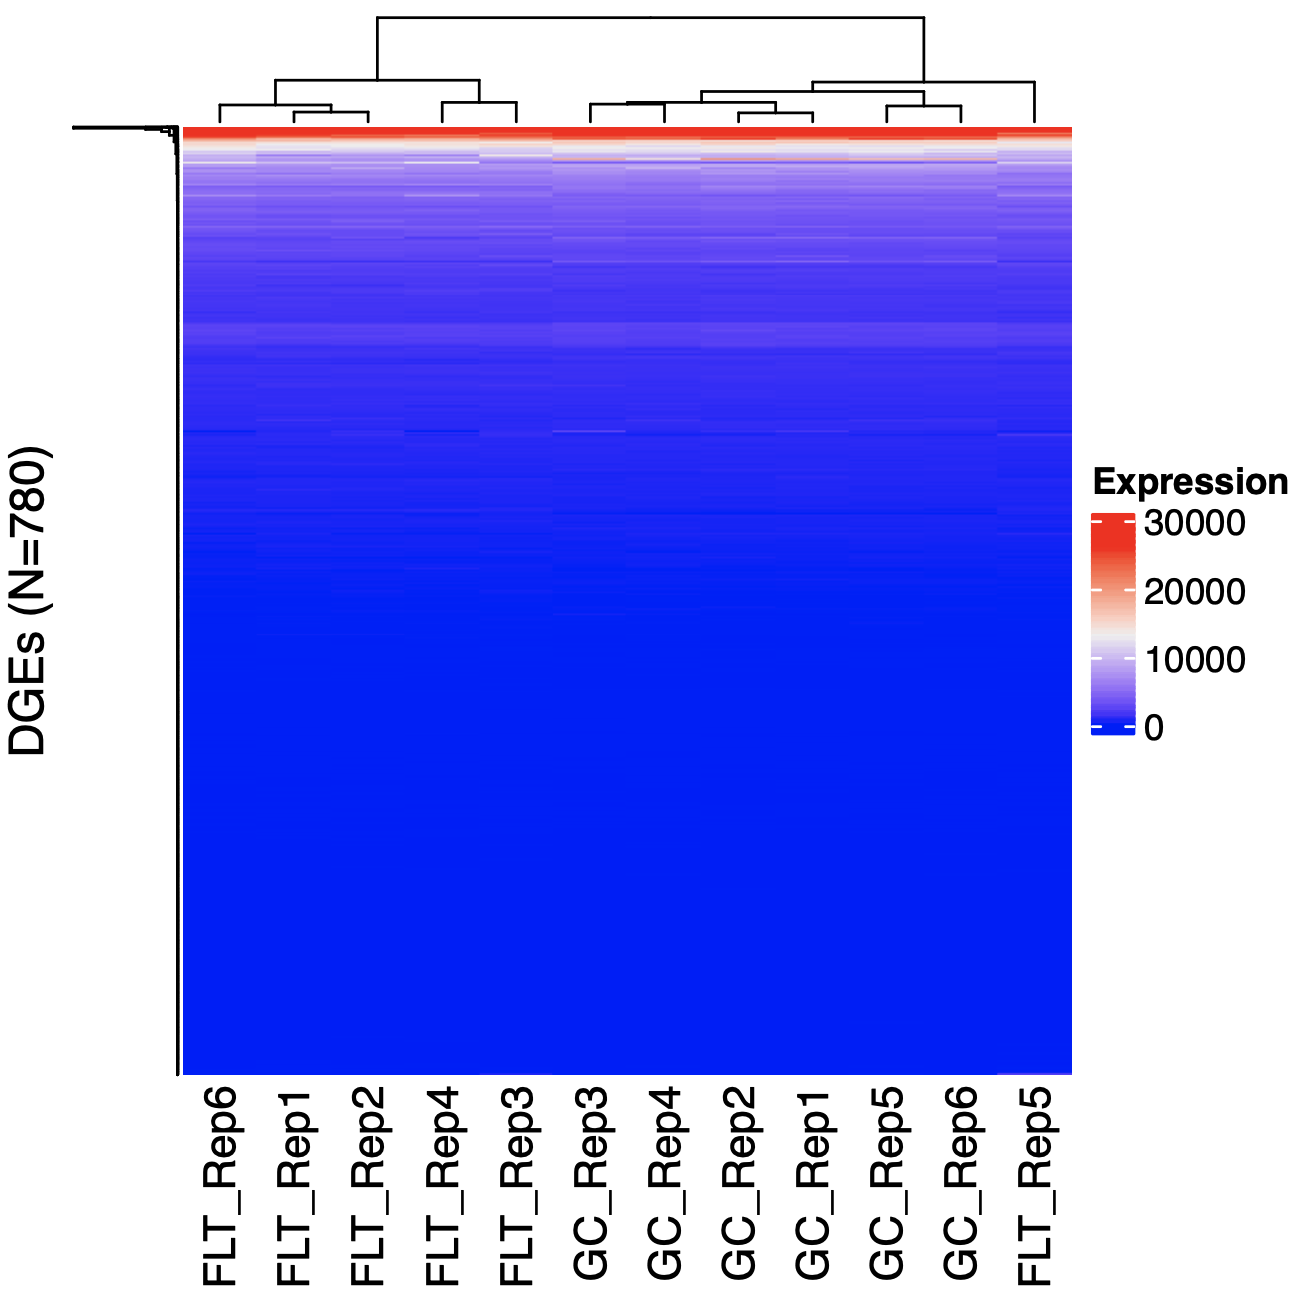

<a class="anchor" id="volcano"></a>
## 5c. Volcano Plot

Next, let's make a volcano plot to identify a few interesting genes. A volcano plot is a scatterplot which shows the relationship of the adjusted p-value to the log2 fold change. Genes with large fold changes that are also statistically significant by adjusted p-value are labeled.

First, we'll define the settings in the `EnhancedVolcano()` function to use the cutoff values that were used above: log2 fold change cutoff > |1|, and an adjusted p-value cutoff of < 0.05. 

>_**Note**_: You can read more about the `EnhancedVolcano()` function and see some examples by clicking [here](https://bioconductor.org/packages/release/bioc/vignettes/EnhancedVolcano/inst/doc/EnhancedVolcano.html).

In [ ]:
## Volcano plot showing genes differentially expressed in group 1 vs group 2 ##
EnhancedVolcano(DGE_output_table,
    lab = DGE_output_table$SYMBOL,
    x = paste("Log2fc_(", g1, ")v(", g2, ")", sep=""),
    y = paste("Adj.p.value_(", g1, ")v(", g2, ")", sep=""),
    title = paste(g1, " vs. ", g2, sep=""),
    legendLabels=c('NS','|Log2FC| > 1','Adj. p-value < 0.05',
      'Adj. p-value < 0.05 & |Log2FC| > 1'),
    pCutoff = 5e-2,
    FCcutoff = 1,
    pointSize = 3.0,
    labSize = 6.0,
    colAlpha=0.5)

## Save your volcano plot ##
ggsave(file.path(DGE_volcano, paste(GLDS, g1mod, "v", g2mod, "volcano_DGE.png", sep="_")), width = 11, height = 8.5, dpi = 300)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `EnhancedVolcano()`:  
    - The function used to create a _volcano plot_ to visualize differentially expressed genes from data in a dataframe (`DGE_output_table`), by plotting log fold change against adjusted p-value.
  
    - `DGE_output_table`:  
        - The data frame containing the differential gene expression results, which includes log fold change, adjusted p-values, and gene symbols.

    - `lab = DGE_output_table$SYMBOL`:  
        - Labels the points (genes) in the volcano plot using the gene symbols stored in the `SYMBOL` column of `DGE_output_table`.

    - `x = paste("Log2fc_(", g1, ")v(", g2, ")", sep="")`:  
        - Defines the x-axis values for the volcano plot, representing the log2 fold change between group 1 and group 2.

    - `y = paste("Adj.p.value_(", g1, ")v(", g2, ")", sep="")`:  
        - Defines the y-axis values for the plot, representing the adjusted p-value for the comparison between group 1 and group 2.

    - `title = paste(g1, " vs. ", g2, sep="")`:  
        - Sets the title of the volcano plot to "group 1 versus group 2".

    - `legendLabels=c('NS','|Log2FC| > 1','Adj. p-value < 0.05', 'Adj. p-value < 0.05 & |Log2FC| > 1')`:  
        - Customizes the labels in the plot legend to represent different categories of significance:  
            - `NS`: Not significant,  
            - `|Log2FC| > 1`: Genes with a log2 fold change greater than 1 or less than -1,  
            - `Adj. p-value < 0.05`: Genes with a significant adjusted p-value, < 0.05,  
            - `Adj. p-value < 0.05 & |Log2FC| > 1`: Genes that meet both significance and fold change criteria.

    - `pCutoff = 5e-2`:  
        - Sets the cutoff for the adjusted p-value to 0.05 (5e-2) to define statistical significance.

    - `FCcutoff = 1`:  
        - Sets the fold change cutoff to 1, so genes with a log2 fold change greater than 1 or less than -1 are considered biologically meaningful.

    - `pointSize = 3.0`:  
        - Specifies the size of the points (genes) in the plot.

    - `labSize = 6.0`:  
        - Sets the size of the gene labels in the plot.

    - `colAlpha=0.5`:  
        - Adjusts the transparency of the points (genes) in the plot.

<br>

- `ggsave()`:  
    - Function used to save the volcano plot as a _PNG_ file in the `DGE_volcano` directory.

    - `file.path(DGE_volcano, paste(GLDS, g1mod, "v", g2mod, "volcano_DGE.png", sep="_"))`:  
        - Creates the file path for saving the volcano plot. In this case, the file will be saved in the `DGE_volcano` directory and named by combining the values held in the `GLDS`, `g1mod`, `g2mod` variables and ending in "volcano_DGE.png".

    - `width = 11, height = 8.5`:  
        - Specifies the dimensions of the saved PNG file (11 inches wide and 8.5 inches high).

    - `dpi = 300`:  
        - Sets the resolution of the saved PNG file to 300 dpi, which is suitable for publication-quality images.

</div>

<br>


**Use the volcano plot (and our collective conscious - aka the internet) to answer the following questions:**

1. Which gene has the smallest adjusted p-value that still passes our Log2FC cutoff?
   
2. Is that gene more highly expressed in `g1` or `g2` samples? How do you know?

3. Which gene is most highly differentially expressed in `g1`? Does this gene also pass the adjusted p-value cutoff?

4. For the most significant differentially expressed gene, see if you can find its biological function (feel free to use a search engine, e.g. Google, to help you out). Are you able to find an annotated function? 

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The gene with the smallest adjusted p-value that still passes our Log2FC cutoff will be the gene with the highest value on the y-axis that is also outside (less than or greater than) the two vertical lines representing our Log2FC cutoff values.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

If the gene has a positive Log2FC value then it is more highly expressed in group 1 samples but if it has a negative Log2FC value then it is more highly expressed in group 2 samples because we plotted the group 1 vs group 2 comparison.

</details>
</div>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

The most highly differentially expressed gene in group 1 is the gene with the largest Log2FC value.  

If that gene is also above the horizontal line, representing our adjusted p-value cutoff, then it does pass the adjusted p-value cutoff.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q4 Solution</b></summary>

<br>

This depends on what the most significant differentially expressed gene is in your dataset. You can search your gene name on [GeneCards](https://www.genecards.org/) to find out more, including an annotated function(s) if available.  

</details>
</div>

<br>

**Challenge:** Use the code blocks below to create another volcano plot (or two) with different adjusted p-value and log2FC cutoffs and see how the plot changes. 
> _**Hint**_: Start with the `EnhancedVolcano()` command above then change the values corresponding to the adjusted p-value and log2FC cutoffs. If you're unsure what those are, take a look at the `EnhancedVolcano()` documentation [here](https://bioconductor.org/packages/release/bioc/vignettes/EnhancedVolcano/inst/doc/EnhancedVolcano.html).

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

One example with the adjusted p-value cutoff more stringient:

```R
EnhancedVolcano(DGE_output_table,
    lab = DGE_output_table$SYMBOL,
    x = paste("Log2fc_(", g1, ")v(", g2, ")", sep=""),
    y = paste("Adj.p.value_(", g1, ")v(", g2, ")", sep=""),
    title = paste(g1, " vs. ", g2, sep=""),
    legendLabels=c('NS','|Log2FC| > 1','Adj. p-value < 0.05',
      'Adj. p-value < 0.05 & |Log2FC| > 1'),
    pCutoff = 5e-8,
    FCcutoff = 1,
    pointSize = 3.0,
    labSize = 6.0,
    colAlpha=0.5)  
```

</details>
</div>

<br>

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

Another example with the adjusted p-value and the log2 fold change cutoffs more stringient:

```R
EnhancedVolcano(DGE_output_table,
    lab = DGE_output_table$SYMBOL,
    x = paste("Log2fc_(", g1, ")v(", g2, ")", sep=""),
    y = paste("Adj.p.value_(", g1, ")v(", g2, ")", sep=""),
    title = paste(g1, " vs. ", g2, sep=""),
    legendLabels=c('NS','|Log2FC| > 1','Adj. p-value < 0.05',
      'Adj. p-value < 0.05 & |Log2FC| > 1'),
    pCutoff = 5e-8,
    FCcutoff = 3,
    pointSize = 3.0,
    labSize = 6.0,
    colAlpha=0.5)  
```

</details>
</div>

<br>

---

<a class="anchor" id="gsea"></a>
## 5d. Gene Set Enrichment Analysis (GSEA)

Finally, let's perform Gene Set Enrichment Analysis ([GSEA](https://www.gsea-msigdb.org/gsea/index.jsp)). GSEA is a computational method used to determine whether predefined sets of genes (such as pathways or functional groups) show statistically significant differences in expression between different experimental conditions (e.g. spaceflight and ground control). 

<br> 

#### Import Organism-Specific R Libraries:

In [ ]:
## Create a function to identify the GeneLab annotations package used for a give organism ##
fetch_organism_specific_annotation_pkg <- function(organism) {
  all_organism_table <- read.csv("https://raw.githubusercontent.com/nasa/GeneLab_Data_Processing/refs/heads/master/GeneLab_Reference_Annotations/Pipeline_GL-DPPD-7110_Versions/GL-DPPD-7110-A/GL-DPPD-7110-A_annotations.csv")
  ann.dbi <- all_organism_table %>% dplyr::filter(species == organism) %>% dplyr::pull(bioconductor_annotations)
  # Generate an error message if the organism does not have an associated annotation file yet
  if (length(ann.dbi) == 0) {
    stop(glue::glue("Organism supplied '{organism}' is not supported. See the following url for supported organisms: https://github.com/nasa/GeneLab_Data_Processing/blob/master/GeneLab_Reference_Annotations/Pipeline_GL-DPPD-7110_Versions/GL-DPPD-7110-A/GL-DPPD-7110-A_annotations.csv.  Supported organisms will correspond to a row based on the 'species' column and include a url in the 'genelab_annots_link' column of that row"))
  }
  return(ann.dbi)
}

## Use the function above to specify the GeneLab annotations package for your organism, defined in the runsheet ##
ann.dbi <- fetch_organism_specific_annotation_pkg(unique(df_rs$organism))

## Import and load the GeneLab annotations package for your organism
ann.dbi=as.character(ann.dbi)
library(ann.dbi, character.only=TRUE)

<br>

#### Set DGE Filtering Parameters

Specify the filtering parameters to use to prepare your DGE output table for subsequent GSEA:

- **mean_exp_cutoff**: Cut off value for the average gene expression across all samples. Genes below this value will be removed. 
- **rank_var**: The DESeq2 results statistic you want to use to rank your features (genes), options include:
  - `Log2fc`: Log(2) fold change
  - `Stat`: Wald statistic 
  - `P.value`: p-value 
  - `Adj.p.value`: p-value adjusted for multiple comparisons testing
- **keytype**: The gene IDs used in your DGE analysis above, options include:
  - `ENSEMBL`: For animals
  - `TAIR`: For plants

In [ ]:
mean_exp_cutoff <- 50
rank_var <- "Stat"
keytype <- "ENSEMBL" ## Change ENSEMBL to TAIR for plant studies ##

<br>

#### Filter DGE Results On Contrast of Interest

In [ ]:
## Pull DESeq2 results columns from the DGE table ##
IDs <- DGE_output_table %>% dplyr::select( !!rlang::sym(keytype))
all_mean <- DGE_output_table %>% dplyr::select(All.mean)
log2fc <- DGE_output_table %>% dplyr::select( !!rlang::sym(paste0("Log2fc_(",g1,")v(",g2,")")))
stat <- DGE_output_table %>% dplyr::select( !!rlang::sym(paste0("Stat_(",g1,")v(",g2,")")))
pvalue <- DGE_output_table %>% dplyr::select( !!rlang::sym(paste0("P.value_(",g1,")v(",g2,")")))
padj <- DGE_output_table %>% dplyr::select( !!rlang::sym(paste0("Adj.p.value_(",g1,")v(",g2,")")))

## Combine all DESeq2 results columns from the DGE table ##
DGE_res <- cbind(IDs, all_mean, log2fc, stat, pvalue, padj)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `IDs <- DGE_output_table %>% dplyr::select( !!rlang::sym(keytype))`:  
    - Selects the column from `DGE_output_table` that matches the `keytype` variable.  
    - `!!rlang::sym(keytype)`: Uses `rlang::sym` to pull the info stored in the `keytype` variable and the `!!` operator to remove the quotes so it can be evaluated within the `dplyr::select()` function.

- `all_mean <- DGE_output_table %>% dplyr::select(All.mean)`:  
    - Selects the `All.mean` column from `DGE_output_table`, which contains the mean expression value for each gene across all samples.

- `log2fc <- DGE_output_table %>% dplyr::select( !!rlang::sym("Log2fc_(",g1,")v(",g2,")") )`:  
    - Selects the column containing the log2 fold change values for the comparison between _group 1_ and _group 2_ conditions.  
    - `!!rlang::sym("Log2fc_(",g1,")v(",g2,")")`: Dynamically references the column name even though it contains special characters (parentheses). This ensures the column is correctly interpreted by `dplyr::select()`.

- `stat <- DGE_output_table %>% dplyr::select( !!rlang::sym("Stat_(",g1,")v(",g2,")") )`:  
    - Selects the column that holds the statistical test values (e.g., Wald statistic) for the _group 1_ vs _group 2_ comparison.

- `pvalue <- DGE_output_table %>% dplyr::select( !!rlang::sym("P.value_(",g1,")v(",g2,")") )`:  
    - Selects the column that contains the raw p-values for the _group 1_ vs _group 2_ comparison.

- `padj <- DGE_output_table %>% dplyr::select( !!rlang::sym("Adj.p.value_(",g1,")v(",g2,")") )`:  
    - Selects the column with the adjusted p-values (corrected for multiple testing) for the _group 1_ vs _group 2_ comparison.

<br>

- `DGE_res <- cbind(IDs, all_mean, log2fc, stat, pvalue, padj)`:  
    - Combines all the selected columns (IDs, All.mean, Log2FC, Stat, P.value, and Adj.p.value) into a new data frame `DGE_res` using `cbind()`.  
    - This new table contains relevant information for each gene, including identifiers, mean expression, log2 fold changes, statistical values, and p-values.

</div>

<br>

Remove low expressing genes from your `DGE_res` table:

In [ ]:
DGE_res <- DGE_res %>% dplyr::filter(All.mean > mean_exp_cutoff)

Look at the dimensions of your `DGE_res` table after filtering low expressing genes:

In [ ]:
dim(DGE_res)

**Use the dimensions of your `DGE_res` table after filtering low expressing genes to answer the following question:**

1. How many genes were removed?

  > *Hint: Subtract this value from the number of features in the `DEG_output_table`*

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The dim() function displays rows by columns, which for us represents genes and samples, respectively. Therefore the number of genes removed is equal to the number of rows in the `DEG_output_table` minus the number of rows in the `DGE_res` table.

</details>
</div>

<br>

Take a look at your `DGE_res` table:

In [ ]:
head(DGE_res)

<br>

#### Rank DGE Results

GSEA requires the input gene list to be ranked in order to evaluate whether genes in the predefined set are primarily located at the top (upregulated) or bottom (downregulated) of the ranked list, thus revealing biologically meaningful trends that may not be apparent from single-gene analyses.

Any of the DESeq2 results columns can be used to rank our gene list. Here we use the Wald statistic, defined in the `rank_var` variable above, to rank our genes, which is commonly used for GSEA.

Rank the features (genes) in our `DGE_res` dataframe using our `rank_var` specified above:

In [ ]:
DGE_res_ranked <- DGE_res %>% dplyr::arrange(desc( !!rlang::sym(paste0(rank_var,"_(",g1,")v(",g2,")"))))

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `DGE_res_ranked <- DGE_res %>% dplyr::arrange(desc( !!rlang::sym(paste0(rank_var,"_(",g1,")v(",g2,")"))))`:  
    - This command ranks (or arranges) the rows of the `DGE_res` data frame based on a specific column, with the order set to _descending_.

    - `DGE_res`:  
        - The data frame holding the DESeq2 results (previously created) which contains the data columns we selected above.

    - `%>%`:  
        - The _pipe operator_ allows for chaining functions together, making the code cleaner and easier to read. It passes `DGE_res` into the next function (`dplyr::arrange`).

    - `dplyr::arrange()`:  
        - A function from the `dplyr` package that _rearranges_ the rows of a data frame based on one or more columns. The default sorting order is ascending unless `desc()` is used.

    - `desc()`:  
        - This ensures that the sorting is done in _descending order_ (from largest to smallest values).

    - `!!rlang::sym(paste0(rank_var,"_(",g1,")v(",g2,")"))`:  
        - Dynamically constructs and evaluates the column name used for ranking.  
        - `paste0(rank_var, "_(",g1,")v(",g2,")")`: Concatenates the values stored in the `rank_var`, `g1`, and `g2` variables to create the full column name. 
        - `!!rlang::sym()`: Converts the concatenated string into a symbol (a reference to a column) and evaluates it, ensuring `arrange()` can use it as the sorting criterion.

</div>

<br>

View your `DGE_res_ranked` table to make sure the data are now ranked in descending order based on your `rank_var` column:

In [ ]:
head(DGE_res_ranked)

Next, we'll extract our sorted `rank_var` column to create our gene list that we will use to perform GSEA:

In [ ]:
gene_list <- DGE_res_ranked %>% dplyr::select( !!rlang::sym(paste0(rank_var,"_(",g1,")v(",g2,")"))) %>% pull

## Add IDs from the DGE_res_ranked dataframe to the gene_list ##
names(gene_list) <- DGE_res_ranked %>% dplyr::select( !!rlang::sym(keytype)) %>% pull

## View your ranked gene_list ##
head(gene_list)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `gene_list <- DGE_res_ranked %>% dplyr::select( !!rlang::sym(paste0(rank_var,"_(",g1,")v(",g2,")"))) %>% pull`:  
    - Creates `gene_list`, a vector that contains the values from a dynamically specified column in the `DGE_res_ranked` data frame.
  
    - `dplyr::select( !!rlang::sym(paste0(rank_var,"_(",g1,")v(",g2,")")))`:  
        - Dynamically constructs the column name by concatenating `rank_var` and `"_(",g1,")v(",g2,")"` to select the column used for ranking.  
        - `!!rlang::sym()`: Converts the constructed string into a symbol to select the column in `dplyr::select()`.
  
    - `pull`:  
        - Extracts the selected column as a vector from the data frame.

- `names(gene_list) <- DGE_res_ranked %>% dplyr::select( !!rlang::sym(keytype)) %>% pull`:  
    - Assigns names to the elements of `gene_list` using IDs from the `DGE_res_ranked` data frame.

    - `dplyr::select( !!rlang::sym(keytype))`:  
        - Dynamically selects the column specified by the `keytype` variable from the `DGE_res_ranked` data frame, which contains the ENSEMBL IDs.

    - `pull`:  
        - Extracts this column as a vector to be used as the names for `gene_list`.

</div>

<br>

<br>

#### Set GSEA Parameters

To perform GSEA, we'll set parameters to specify how we want the analysis performed. Here is a description of the parameters we'll be specifying in the code block below:

- **ont**: The sub-ontology to use, options include:
  - `BP`: Biological Processes
    > Focuses on the pathways and larger biological processes in which a gene product is involved. Examples include processes like cell division, immune response, or signal transduction. 
  - `MF`: Molecular Function
    > Describes the biochemical activities of gene products at the molecular level. Examples include functions like enzyme activity, binding affinity, or transport activity. 
  - `CC`: Cellular Component
    > Refers to where gene products are located within a cell or their subcellular structures. Examples include mitochondria, nucleus, cell membrane, or protein complexes. 
  - `ALL`: Use all three sub-ontologies
- **minGSSize**: Minimum size of a gene set for testing. Gene sets containing a total number of genes below this threshold will be excluded.
- **maxGSSize**: Maximum size of a gene set for testing. Gene sets containing a total number of genes above this threshold will be excluded.
- **pvalueCutoff**: The adjusted p-value cutoff on enrichment tests to report.
- **pAdjustMethod**: Method to use to correct for multiple comparisons testing, options include:
> You can learn more about each of the methods listed below in [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5506159/).
  - `holm`: Holm adjustment
  - `hochberg`: Hochberg adjustment
  - `hommel`: Hommel adjustment
  - `bonferroni`: Bonferroni adjustment
  - `BH`: Benjamini-Hochberg adjustment
  - `BY`: Benjamini and Yekutieli adjustment
  - `fdr`: false discovery rate
  - `none`: Do not correct for multiple comparisons testing

In [ ]:
ont <- "BP"
minGSSize <- 10
maxGSSize <- 500
pvalueCutoff <- 0.05
pAdjustMethod <- "BH"

<br>

#### Run GSEA Using Gene Ontology (GO)

In this section we will use geneset enrichment analyses provided in the [clusterProfiler](https://bioconductor.org/packages/release/bioc/html/clusterProfiler.html) package on [Bioconductor](http://www.bioconductor.org/). There are a variety of different tools in `clusterProfiler` that allow you to run GSEA using several different types of gene sets. Here we use the genesets associated with the [gene ontologies (GO)](http://geneontology.org/) of our species of interest. You are welcome (and encouraged) to check out the [clusterProfiler](https://bioconductor.org/packages/release/bioc/manuals/clusterProfiler/man/clusterProfiler.pdf) documentation and set up additional code blocks to run GSEA using different types of gene sets.

In [ ]:
gse <- gseGO(geneList = gene_list,
             ont = ont,
             keyType = keytype,
             minGSSize = minGSSize,
             maxGSSize = maxGSSize,
             pvalueCutoff = pvalueCutoff,
             pAdjustMethod = pAdjustMethod,
             OrgDb = ann.dbi,
             by = "fgsea")

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `gse <- gseGO(geneList = gene_list, ont = ont, keyType = keytype, minGSSize = minGSSize, maxGSSize = maxGSSize, pvalueCutoff = pvalueCutoff, pAdjustMethod = pAdjustMethod, OrgDb = ann.dbi, by = "fgsea")`:  
    - This command performs _Gene Set Enrichment Analysis (GSEA)_ using the _Gene Ontology (GO)_ framework, analyzing the ranked `gene_list` to identify enriched gene sets in a specific ontology (e.g., Biological Process, Molecular Function, or Cellular Component).

    - `gseGO()`:  
        - A function from the `clusterProfiler` R package that performs GSEA specifically for Gene Ontology. It evaluates whether any GO terms are significantly enriched at the top or bottom of the ranked gene list.

    - `geneList = gene_list`:  
        - The ranked list of genes we generated above that GSEA will analyze for enrichment.

    - `ont`, `keyType`, `minGSSize`, `maxGSSize`, `pvalueCutoff`, `pAdjustMethod`:  
        - Specifies the parameters described [above](#Set-GSEA-Parameters).

    - `OrgDb = ann.dbi`:  
        - The organism-specific annotation database used to map gene identifiers to GO terms. Recall that `ann.dbi` is the variable we set in [step 4b](#4b.-Add-Gene-Annotations) above.

    - `by = "fgsea"`:  
        - Specifies the algorithm used for GSEA. Here, `"fgsea"` refers to _fast GSEA_, a more efficient algorithm for computing GSEA results, especially useful for large gene sets.

</div>

<br>

Next we will convert the results of our GSEA to a dataframe and save it as a CSV file, then view our GSEA output table:

<div class="alert alert-block alert-info">
<b>GSEA output table content</b><br>

The GSEA output table contains the following columns:

- **ID**: Gene set IDs, here we are using Gene Ontologies (GO).
- **Description**: Indicates the name of the sub-ontology set, the sub-ontology set type defined as the `ont` variable specified above.
- **setSize**: The number of genes in the gene set, after filtering out genes that are not present in the input expression dataset.
- **enrichmentScore**: Unnormalized enrichment score (ES), determined based on how much a gene set is overrepresented at the top or bottom of a ranked list of genes. A positive ES indicates gene set enrichment at the top of the ranked list whereas a negative ES indicates gene set enrichment at the bottom of a ranked list.
- **NES**: Normalized enrichment score, the ES after correcting for differences in ES between gene sets due to differences in the size of the gene sets evaluated.
- **pvalue**: An enrichment p-value representing the statistical significance of the ES, which does not take into account differences in gene set size and has not been adjusted for multiple hypothesis testing. (This is not a useful metric to determine significance.)
- **p.adjust**: A p-value adjusted for multiple testing using the correction method specified with the `pAdjustMethod` variable above.
- **qvalue**: A measure of the false discovery rate (FDR), which is the estimated probability that a gene set with a given NES represents a false positive finding. The closer the qvalue is to zero, the greater the perturbation of the gene set.
  > _Note: Although q-values are always positive (between 0 and 1), the gsea augments the value with either a positive or negative sign to indicate up-regulation or down-regulation, respectively, of a gene set._
- **rank**: The position in the ranked list at which the maximum enrichment score occurred. Genesets that achieve the maximum enrighment score towards the top or bottom of the ranked list provided are the most interesting.
- **leading_edge**: 3 statistics that define the leading edge subset of a gene set, which is the subset of members of the gene set that contribute the most to the ES.
   - **tags**: The % of gene hits before (for positive ES) or after (for negative ES) the peak in the running enrichment score, which indicates the % of genes in the gene set contributing to the ES.
   - **list**: The % of genes in the ranked gene list before (for positive ES) or after (for negative ES) the peak in the running enrichment score, which indicates where in the list the ES is attained.
   - **signal**: The enrichment signal strength that contributes to the 2 statistics described above. A maximal signal strength (100%) occurs if all genes in the gene set are within the very top (or bottom) of the ranked list of genes, and a minimal signal strength (0%) occurs if the genes in the gene set are spread throughout the ranked gene list. 
- **core_enrichment**: Genes that contribute to the leading edge subset of the gene set, these genes contribute most to the enrichment result.


<br>

**To learn more about how to interpret GSEA results check out the "Interpreting GSEA Results" section of the [GSEA User Guide](http://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html).**

</div>

<br>

In [ ]:
gse_table <- as.data.frame(gse)

## Save the GSEA output table to a file ##
write.csv(gse_table,file.path(DGE_gsea, paste(GLDS, g1mod, "v", g2mod, "GSEA", rank_var, "ranked_output.csv", sep="_")))

head(gse_table)

**Take a look at the gene ontologies shown above and answer the following questions:**

1. Which gene ontology (of the ones shown) is the most enriched in group 1? What about group 2?
   
2. Is the most enriched GO in group 1 significantly enriched? What about the most enriched GO in group 2?

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The most enriched gene ontology in group 1 is the GO that has the largest _positive_ normalized enrichment (NES) score value of the ones shown. 

The most enriched gene ontology in group 2 is the GO that has the largest _negative_ normalized enrichment (NES) score value of the ones shown. 

> _Note: Since the ranked gene list used was derived from the group 1 vs group 2 comparison, positive enrichment scores indicate the GO is enriched in group 1 and negative enrichment scores indicate the GO is enriched in group 2._

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

If the most enriched GO in group 1 and in group 2 have an adjusted p-value less than 0.05 then those gene ontologies are significantly enriched in each respective group.

</details>
</div>

<br>

#### Create Dotplot of GSEA GO Results

Use the GSEA GO results above to create a dotplot to visualize the gene ontologies that are activated and suppressed in your specified contrast.
> _**Note**_: The `showCategory` parameter below can be changed to show more or less gene ontologies.

In [ ]:
require(DOSE)
dotplot(gse, showCategory=10, split=".sign") + facet_grid(.~.sign)

## Save your dotplot ##
ggsave(file.path(DGE_gsea, paste(GLDS, g1mod, "v", g2mod, "GSEA", rank_var, "ranked_dotplot.png", sep="_")), width = 11, height = 8.5, dpi = 300)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `require(DOSE)`:  
    - Loads the `DOSE` package in R, which is used for gene set enrichment analysis (GSEA) and visualization.  
    - `DOSE` provides tools for enrichment analysis for Disease Ontology (DO), KEGG, and Reactome, and works with results from GSEA functions like `gseGO()`.

- `dotplot(gse, showCategory=10, split=".sign")`:  
    - `dotplot()`: A function from the `DOSE` package (also available in `clusterProfiler`) to visualize the enrichment results as a dot plot.  
    - `gse`: The object containing the GSEA results generated from the `gseGO()` function.  
    - `showCategory=10`: Specifies the number of categories (e.g., GO terms or pathways) to display in the plot. Here, it shows the top 10 enriched categories.  
    - `split=".sign"`: Splits the plot based on the _sign of the enrichment score_ (positive or negative), allowing for a clearer distinction between upregulated and downregulated categories.

- `+ facet_grid(.~.sign)`:  
    - `facet_grid(.~.sign)`: Creates a faceted plot, where the enrichment results are separated based on the _sign of the enrichment score_ (positive vs. negative).  
    - This allows you to visualize which categories are upregulated (positive NES) and downregulated (negative NES) in separate panels within the same plot.

</div>

<br>

**Use the Dotplot shown above to answer the following questions:**

1. Which of the biological processes shown above has the largest percent of genes represented?
> _**Hint**: The GeneRatio indicates the number of genes in the input list that are associated with a particular gene set to the total number of genes in that set._
   
2. Are the biological processes with the largest percent of genes represented up-regulated in group 1 or group 2?

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The biological process(es) that have the largest percent of genes represented are those that have the highest GeneRatio value.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

If the biological process(es) with the largest percent of genes is in the activated column then they are up-regulated in group 1. If the biological process(es) with the largest percent of genes is in the suppressed column then they are up-regulated in group 2.

</details>
</div>

<br>

<br>

#### Create an Enrichment Map of GSEA GO Results

Use the GSEA GO results above to organize the enriched gene ontologies into a network with edges connecting over-lapping gene sets. Note that overlapping gene sets (ontologies) cluster together. 
> _**Note**_: The `showCategory` parameter below can be changed to show more or less gene ontologies.

In [ ]:
gse_pairwise_termsim <- pairwise_termsim(gse)
emapplot(gse_pairwise_termsim, showCategory = 10)

## Save your network enrichment map ##
ggsave(file.path(DGE_gsea, paste(GLDS, g1mod, "v", g2mod, "GSEA", rank_var, "ranked_network_map.png", sep="_")), width = 11, height = 8.5, dpi = 300)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `gse_pairwise_termsim <- pairwise_termsim(gse)`:  
    - Calculates pairwise _term similarities_ between enriched gene sets from the GSEA results object `gse`.
    - `pairwise_termsim()`:  
        - A function from the `clusterProfiler` package that computes semantic similarities between enriched terms (like GO terms or pathways) based on their shared genes or functional overlap. This helps identify relationships between the enriched terms.
    - `gse`:  
        - The GSEA results object, previously generated using `gseGO()`. This contains the enriched gene sets (e.g., GO terms) and their significance, which is now used to compute pairwise similarities.

- `emapplot(gse_pairwise_termsim, showCategory = 10)`:  
    - Creates an _enrichment map plot_ using the pairwise similarities between enriched terms.
    - `emapplot()`:  
        - A function from the `clusterProfiler` package that generates a network-like visualization (an _enrichment map_) to show relationships between enriched gene sets. Each node represents a gene set (e.g., a GO term), and edges indicate similarity between terms.
    - `gse_pairwise_termsim`:  
        - The object containing pairwise term similarities from the `pairwise_termsim()` function, which is used to create the enrichment map plot.
    - `showCategory = 10`:  
        - Limits the plot to showing the top 10 enriched categories (e.g., GO terms) in the enrichment map. This helps to focus on the most significant terms and their relationships.

</div>

<br>

**Use the Enrichment map plot shown above to answer the following question:**

1. Which biological processes shown have some of the same genes in their gene sets?
   
<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

Biological processes that share common genes in their gene sets are those that are connected by edges in the enrichment map.

</details>
</div>

<br>

---

At the end of every R session, it is good practice to print the session info to record all the packages that were used and their respective versions.

Run the following command to print the session info:

In [ ]:
## print session info ##
print(" ")
print("Session Info below: ")
sessionInfo()

## 6. So now what?

Above we performed some of the standard steps to begin to analyze RNAseq data. The list of significantly differentially expressed genes and biological processes we identified between group 1 and group 2 can be used as a guide to help generate new hypotheses about the biological impacts of spaceflight on muscles. If there are additional contrasts in this dataset you would like to analyze, jump back up to [step 5](#5.-DGE-Data-Visualization) and change the values for `g1` and `g2` to the next two groups you would like to compare and re-run all subsequent analyses. 


---
---

<div style="text-align: right"><a href="01-RNAseq_processing.ipynb"><b>Back to:</b> 1. RNAseq processing</a></div>
